$$
{\huge \textbf{Dark-Fiber Charakterisierung}}\\
$$

$$
{\huge \textbf{für entanglement polarisierter QKD}}\\ 
$$

$$
{\normalsize \textbf{Aufbereitung und Analyse der Messdaten nach Tageszyklen}}
$$

**Autor:** Laura Komma  
**Datensatz:** Nordhausen - Sundhausen

# Aufbereitung der Messdaten
## Ressourcen und Literatur
- [Messdaten](https://zenodo.org/uploads/15183223)
- [Messgerät](https://www.thorlabs.com/_sd.cfm?fileName=MTN007790-D02.pdf&partNumber=PAX1000IR2/M)
- [Plotting-Tool "py_pol"](https://py-pol.readthedocs.io/en/master/index.html)

## Verwendete Libraries / Softwaretools

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import io
import datetime
from IPython.display import Image

from scipy.stats import norm
from scipy.signal import butter, filtfilt

from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

## Eigene Hilfsfunktionen

In [3]:
def format_time(x, pos):
    h = int(x) // 3600
    m = (int(x) % 3600) // 60
    return f"{h:02d}:{m:02d}"

In [4]:
def lowpass(data, box = 100):
    box = box
    LP_filter = np.full(int(box), 1/box) 
    lps = np.convolve(ydata, LP_filter)
    lps = lps[ int((box-1) / 2) :len(lps) - int((box - 1) / 2)]
    return lps

def highpass(data, box = 100):
    lps = lowpass(data, box)
    hps = data - lps[:-1]
    return hps

In [5]:
def butter_filter(data, cutoff, fs=18, order=4, btype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
def convert_angel(az, el):
    az = np.array(az) * degrees
    el = np.array(el) * degrees
    
    x = np.cos(2*el) * np.cos(2*az)
    y = np.cos(2*el) * np.sin(2*az)
    z = np.sin(2*el)
    return x, y, z

In [7]:
def calculate_freq(x, y, z):
    bins = 50
    coords = np.vstack((x, y, z)).T
    hist, edges = np.histogramdd(coords, bins=bins)

    # Indices for each coordinate pair (with clipping)
    bin_indices = [
        np.clip(np.digitize(x, edges[0]) - 1, 0, bins - 1),
        np.clip(np.digitize(y, edges[1]) - 1, 0, bins - 1),
        np.clip(np.digitize(z, edges[2]) - 1, 0, bins - 1)
    ]
    freq = hist[bin_indices[0], bin_indices[1], bin_indices[2]]
    
    return freq

In [8]:
def plot_poincare(x, y, z, freq, elev=15, azim=45, title="Not given"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Poincaré-Sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1, edgecolor='k', linewidth=0.5)

    # Axes
    ax.plot([0, 1.6], [0, 0], [0, 0], color='red')     # +S1
    ax.plot([0, -1.6], [0, 0], [0, 0], color='red')    # -S1
    ax.plot([0, 0], [0, 1.6], [0, 0], color='green')   # +S2
    ax.plot([0, 0], [0, -1.6], [0, 0], color='green')  # -S2
    ax.plot([0, 0], [0, 0], [0, 1.4], color='blue')    # +S3
    ax.plot([0, 0], [0, 0], [0, -1.4], color='blue')   # -S3

    # Labeling Axes
    ax.text( 2.0, 0, 0,  'S1',  color='red', fontsize=10)
    ax.text(-1.8, 0, 0, '-S1',  color='red', fontsize=10)
    ax.text( 0, 1.8, 0,  'S2',  color='green', fontsize=10)
    ax.text( 0, -2.0, 0, '-S2',  color='green', fontsize=10)
    ax.text( 0, 0, 1.6, 'S3',   color='blue', fontsize=10)
    ax.text( 0, 0, -1.6, '-S3',  color='blue', fontsize=10)

    # Measurement
    sc = ax.scatter(x, y, z, c=freq, cmap='hot', s=15)
    plt.colorbar(sc, label='density')

    # Scaling
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    # Aligning Poincaré-Sphere
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title(title)

    plt.show()

## Datenaufbereitungsschritte

In [9]:
filename ='29.11.2024_10d.csv'
skip = 8
sep = ";"

In [10]:
columns = ['Time[date hh:mm:ss] ', ' Elapsed Time [hh:mm:ss:ms]', ' Normalized s 1 ', ' Normalized s 2 ', ' Normalized s 3 ', ' S 0 [mW]', ' S 1 [mW]', ' S 2 [mW]', ' S 3 [mW]', ' Azimuth[°] ', ' Ellipticity[°] ', ' DOP[%] ', ' DOCP[%] ', ' DOLP[%] ', ' Power[mW] ', ' Pol Power[mW] ', ' Unpol Power[mW] ', ' Power[dBm] ', ' Pol Power[dBm] ', ' Unpol Power[dBm] ', ' Power-Split-Ratio ', ' Phase Difference[°] ', ' Warning']
for c in range(len(columns)):
    print(c, ': ', columns[c])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

0 :  Time[date hh:mm:ss] 
1 :   Elapsed Time [hh:mm:ss:ms]
2 :   Normalized s 1 
3 :   Normalized s 2 
4 :   Normalized s 3 
5 :   S 0 [mW]
6 :   S 1 [mW]
7 :   S 2 [mW]
8 :   S 3 [mW]
9 :   Azimuth[°] 
10 :   Ellipticity[°] 
11 :   DOP[%] 
12 :   DOCP[%] 
13 :   DOLP[%] 
14 :   Power[mW] 
15 :   Pol Power[mW] 
16 :   Unpol Power[mW] 
17 :   Power[dBm] 
18 :   Pol Power[dBm] 
19 :   Unpol Power[dBm] 
20 :   Power-Split-Ratio 
21 :   Phase Difference[°] 
22 :   Warning


# Polarisationsgrad (DOP [%])

In [11]:
degree = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[11]])

In [12]:
degree[columns[0]] = pd.to_datetime(degree[columns[0]])
degree.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [13]:
degree_daily = degree.groupby(degree.index.date)
degree_daily_list = list(degree_daily)

In [14]:
for date, df_day in degree_daily_list:
    print(date, '\n')
    print(df_day.describe())
    print('')

2024-11-29 

            DOP[%] 
count  1.676194e+06
mean   9.956919e+01
std    7.112112e+00
min   -3.703300e+03
25%    9.688000e+01
50%    9.967000e+01
75%    1.024400e+02
max    2.895590e+03

2024-11-30 

            DOP[%] 
count  1.500099e+06
mean   9.981857e+01
std    3.211169e+00
min    8.088000e+01
25%    9.752000e+01
50%    9.969000e+01
75%    1.022700e+02
max    1.242400e+02

2024-12-01 

            DOP[%] 
count  1.429572e+06
mean   9.977245e+01
std    3.271031e+00
min    7.374000e+01
25%    9.734000e+01
50%    9.938000e+01
75%    1.022900e+02
max    1.350300e+02

2024-12-02 

            DOP[%] 
count  1.368538e+06
mean   1.001463e+02
std    3.223490e+00
min    8.404000e+01
25%    9.781000e+01
50%    9.985000e+01
75%    1.025800e+02
max    1.164700e+02

2024-12-03 

            DOP[%] 
count  1.117895e+06
mean   9.903248e+01
std    4.732648e+00
min   -4.618900e+02
25%    9.733000e+01
50%    9.897000e+01
75%    1.007900e+02
max    2.062070e+03



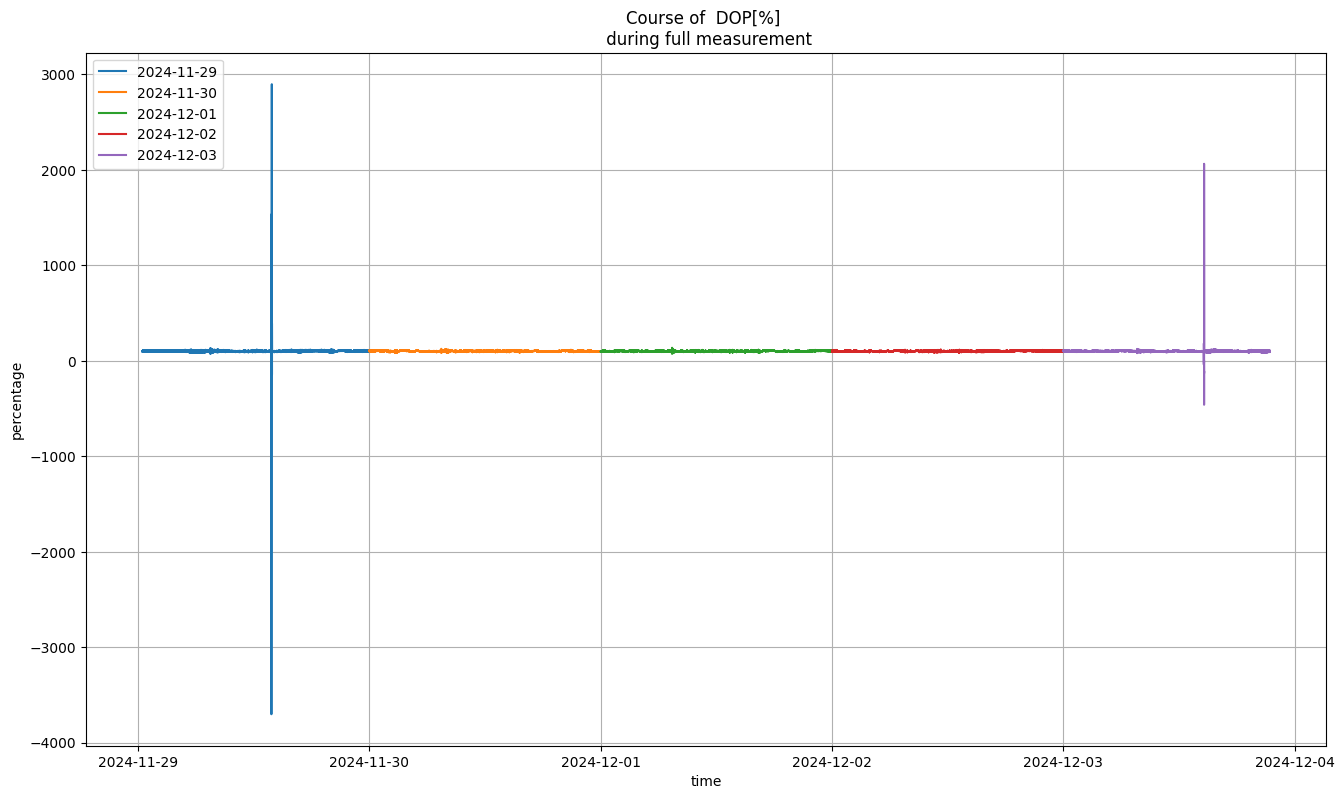

In [15]:
plt.figure(figsize = (16,9))
for date, df_day in degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date))
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[11]}\n during full measurement')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

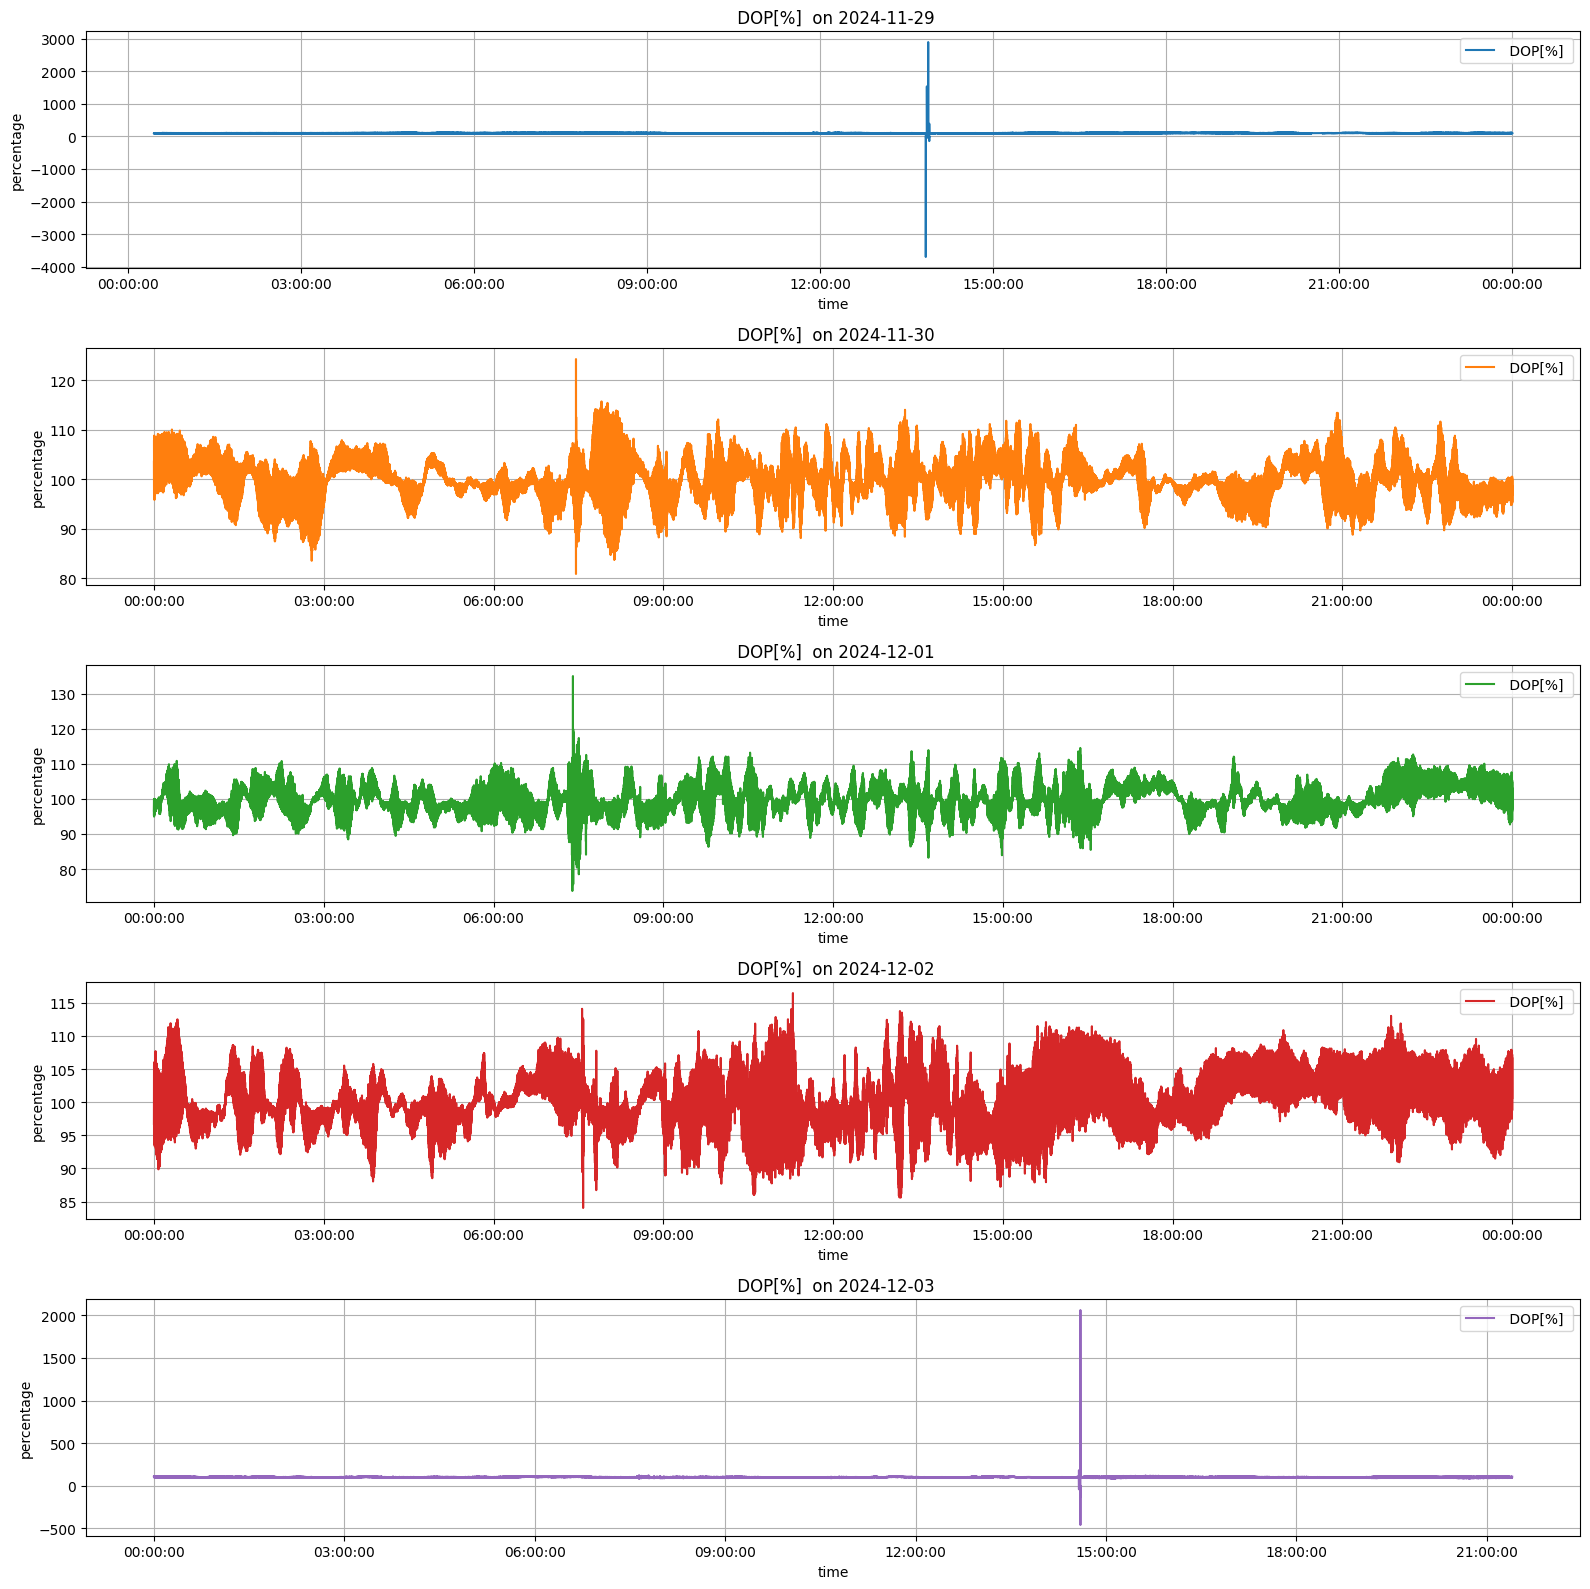

In [16]:
fig, axs = plt.subplots(len(degree_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(degree_daily_list)):
    ax = axs[i] if len(degree_daily_list) > 1 else axs
    df_day = degree_daily_list[i][1]

    ax.plot(df_day.index, df_day, label=columns[11], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[11]} on {degree_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('percentage')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

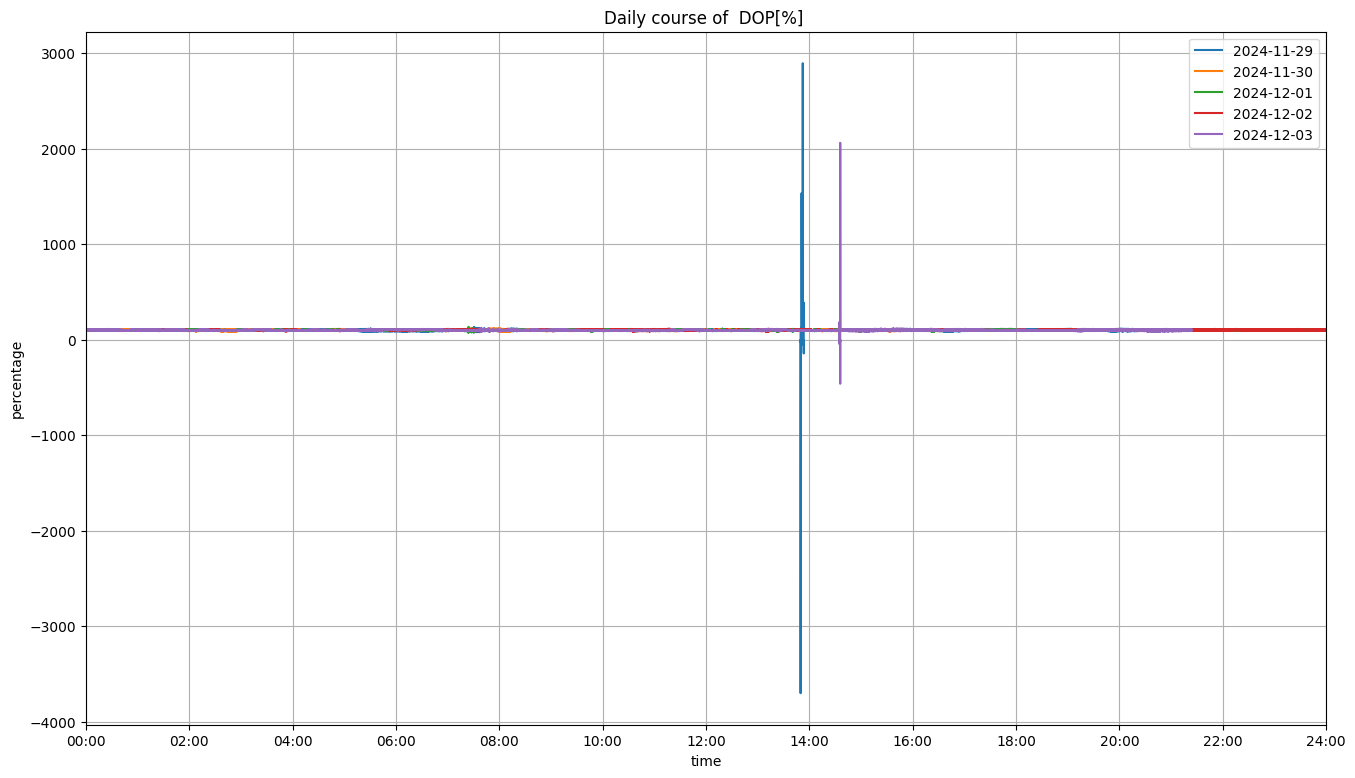

In [17]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Daily course of {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Stundenweise Aufteilung (Beispiel: erster Tag)

In [18]:
# exemplary day
day = 0 #first day

In [19]:
degree_one_day = degree_daily_list[day][1]
hourly = degree_one_day.groupby(degree_one_day.index.hour)
degree_hourly = list(hourly)

In [20]:
for hour, df_hour in degree_hourly:
    print(f'{hour}:00\n')
    print(df_hour.describe())
    print('')

0:00

            DOP[%] 
count  41275.000000
mean      98.782586
std        2.762127
min       92.610000
25%       96.120000
50%       99.190000
75%      101.250000
max      106.270000

1:00

            DOP[%] 
count  74616.000000
mean      98.671192
std        2.760749
min       92.290000
25%       96.050000
50%       98.895000
75%      101.180000
max      106.340000

2:00

            DOP[%] 
count  74706.000000
mean      99.697654
std        2.657860
min       93.690000
25%       97.170000
50%       99.890000
75%      102.180000
max      106.550000

3:00

            DOP[%] 
count  74791.000000
mean     100.668886
std        2.529215
min       94.970000
25%       98.290000
50%      100.970000
75%      102.970000
max      107.430000

4:00

            DOP[%] 
count  74793.000000
mean     101.770583
std        2.758068
min       89.800000
25%       99.520000
50%      101.790000
75%      103.920000
max      113.100000

5:00

            DOP[%] 
count  74747.000000
mean      98.515741

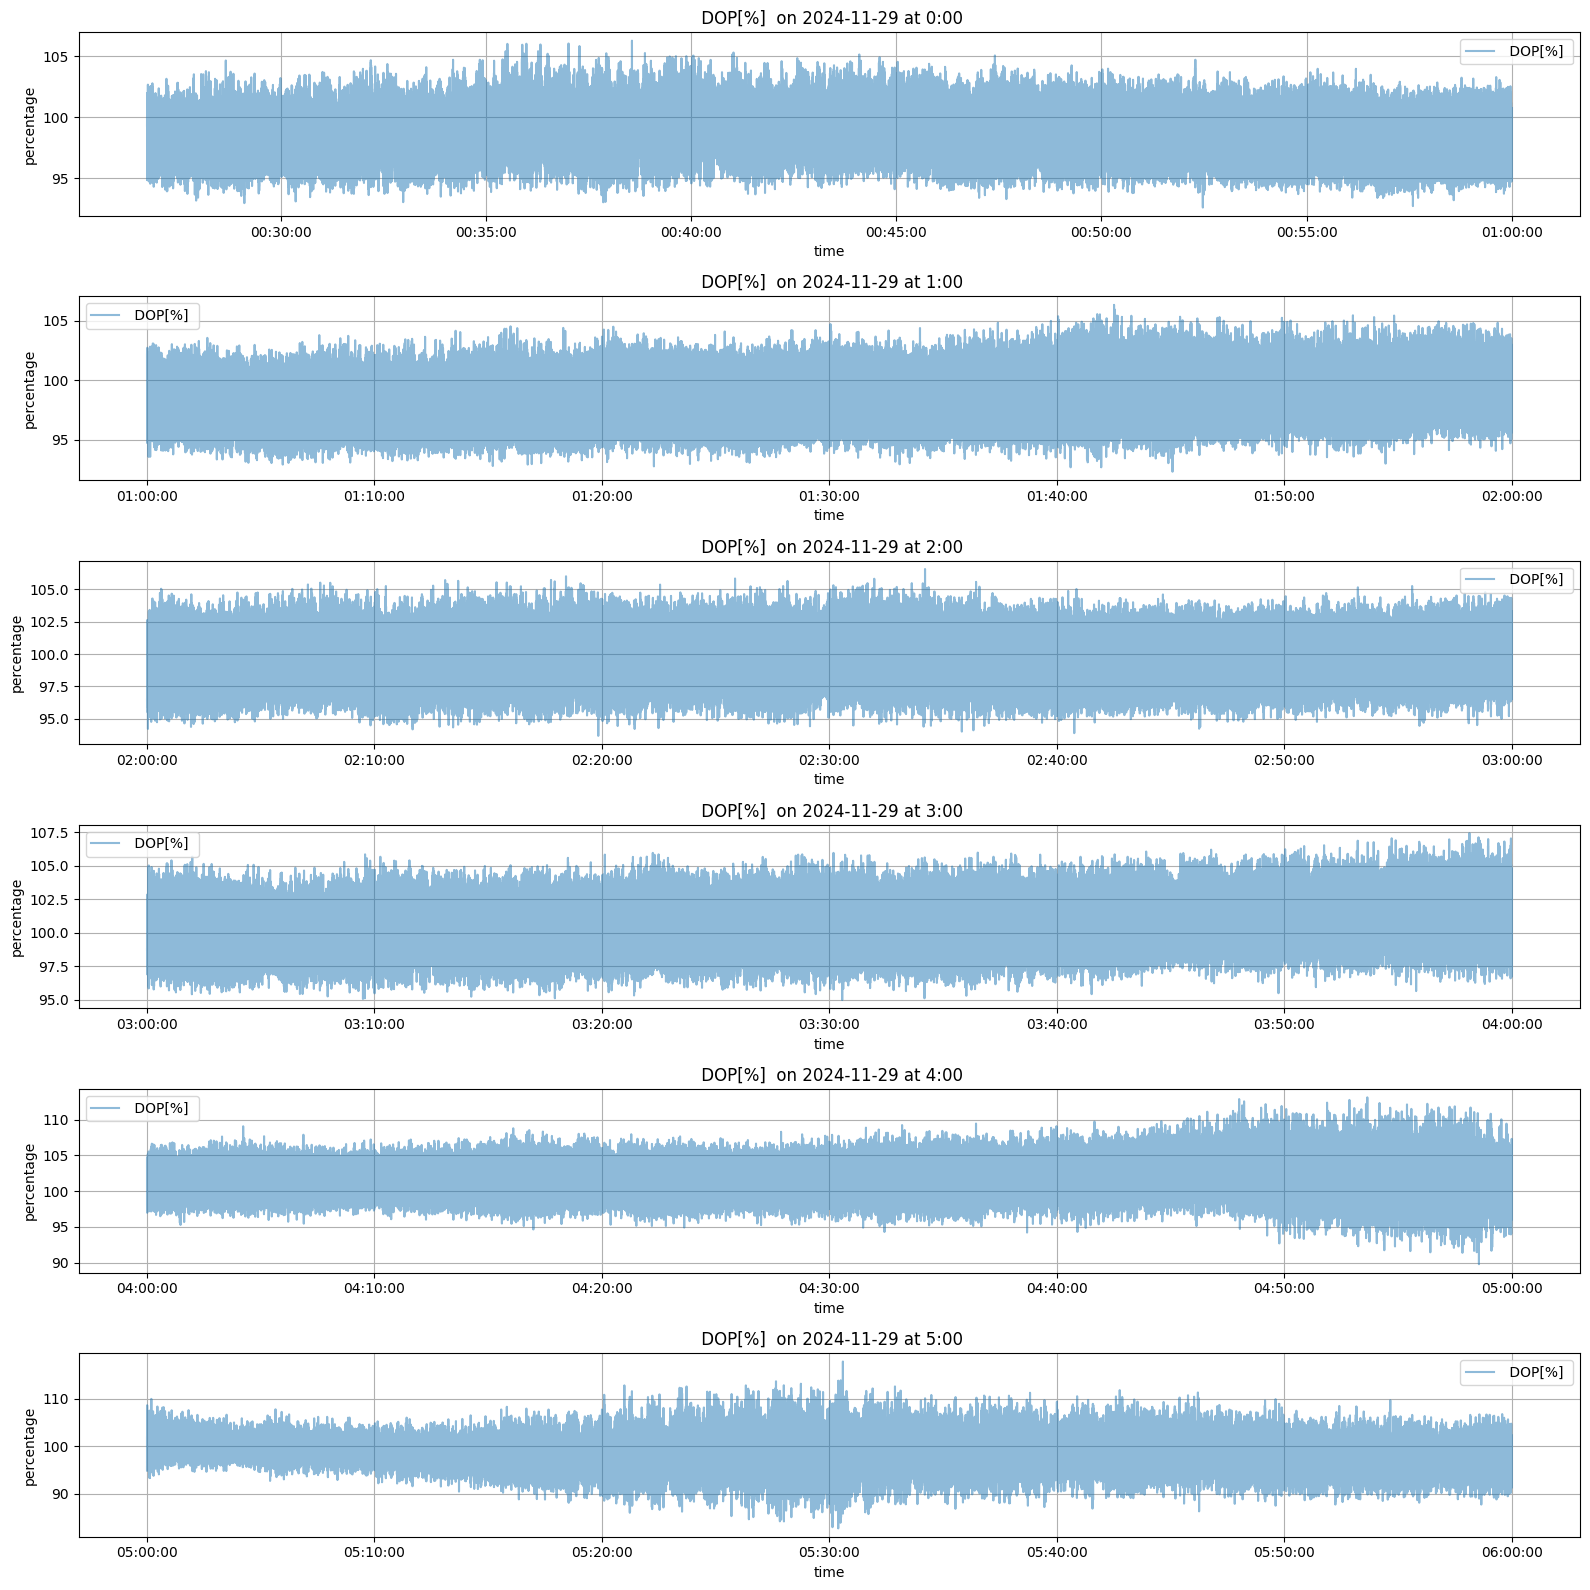

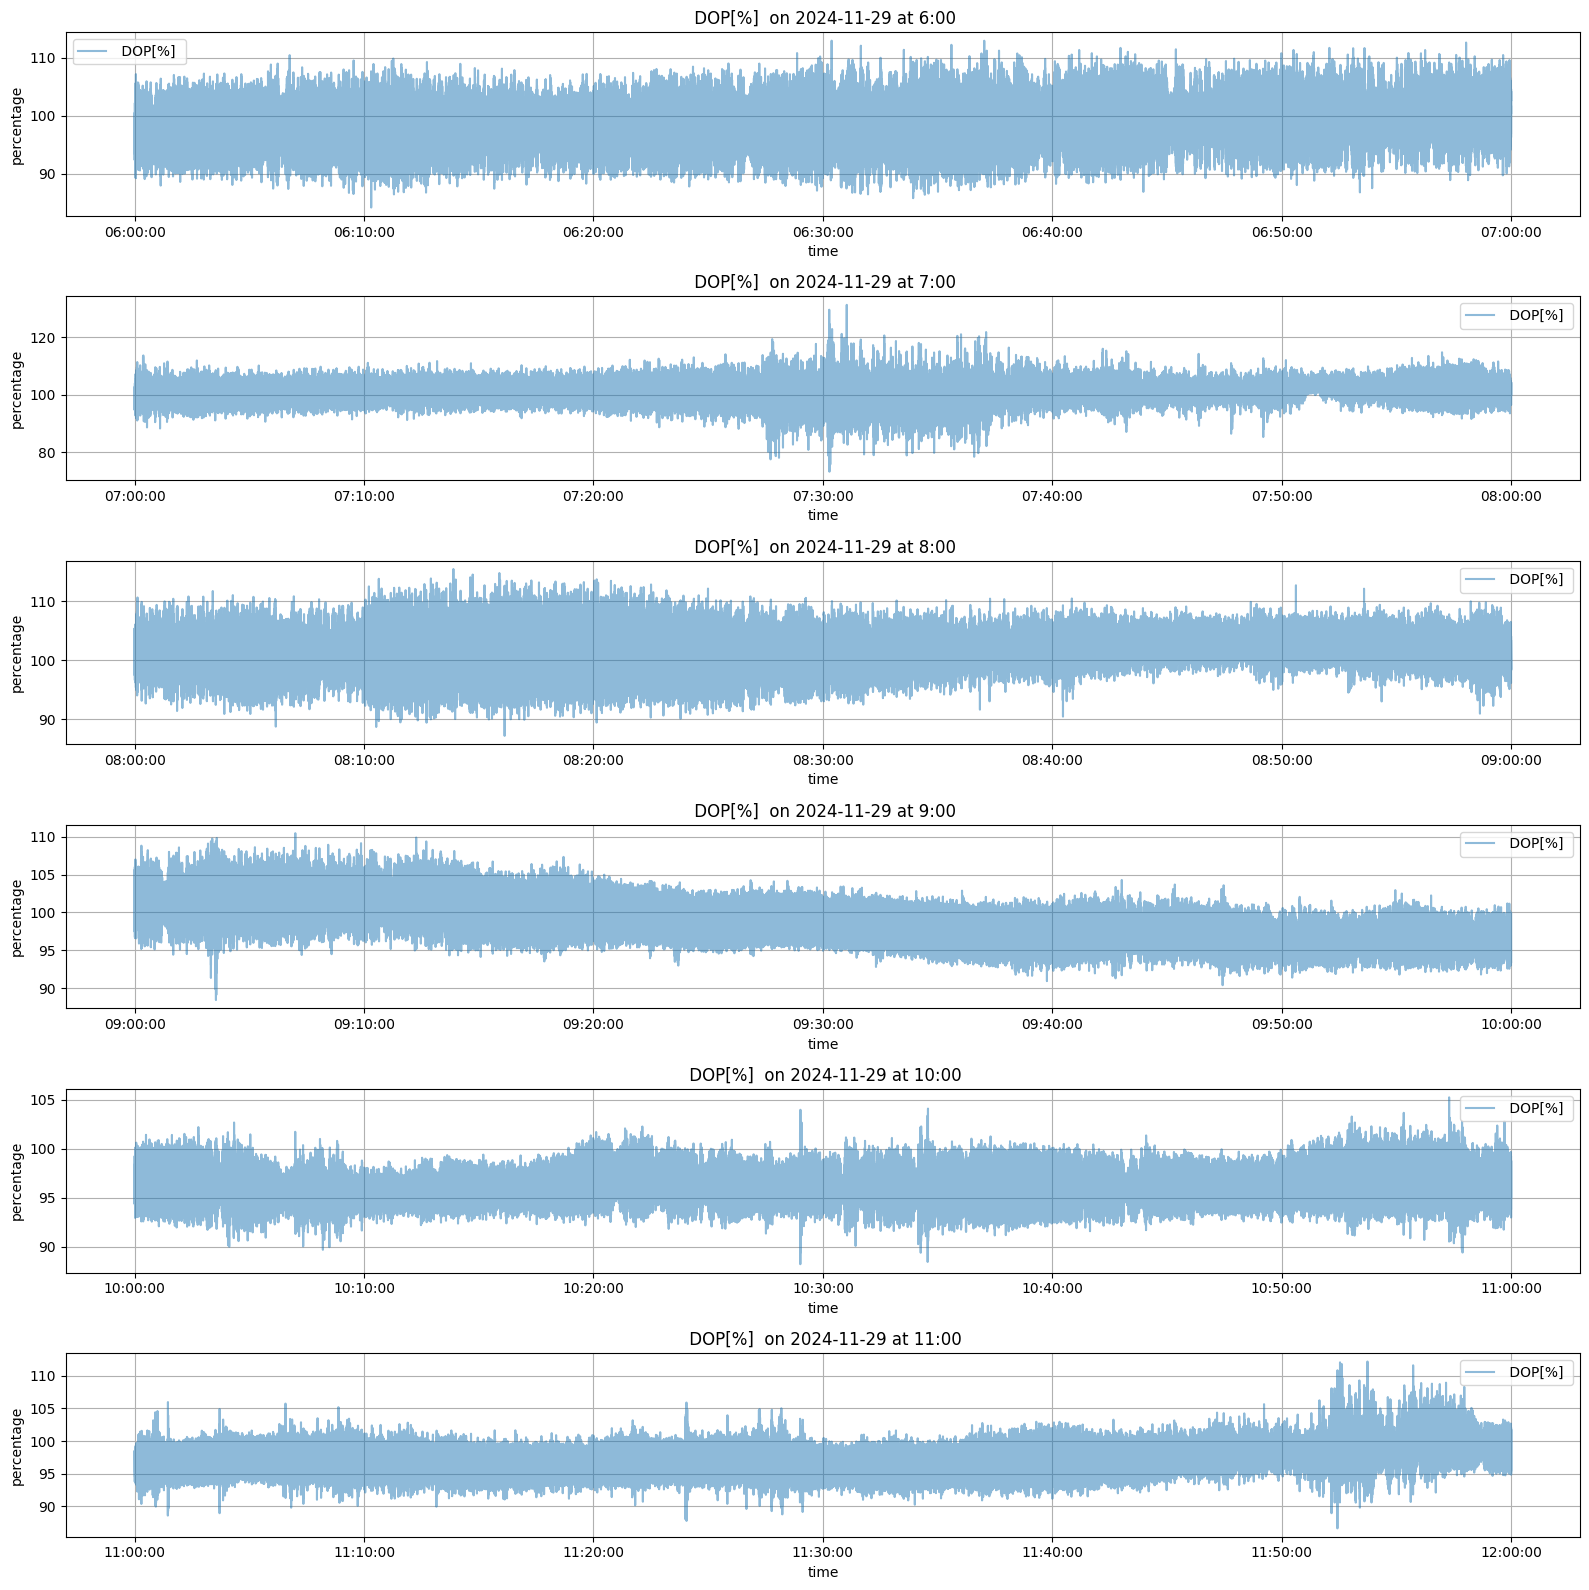

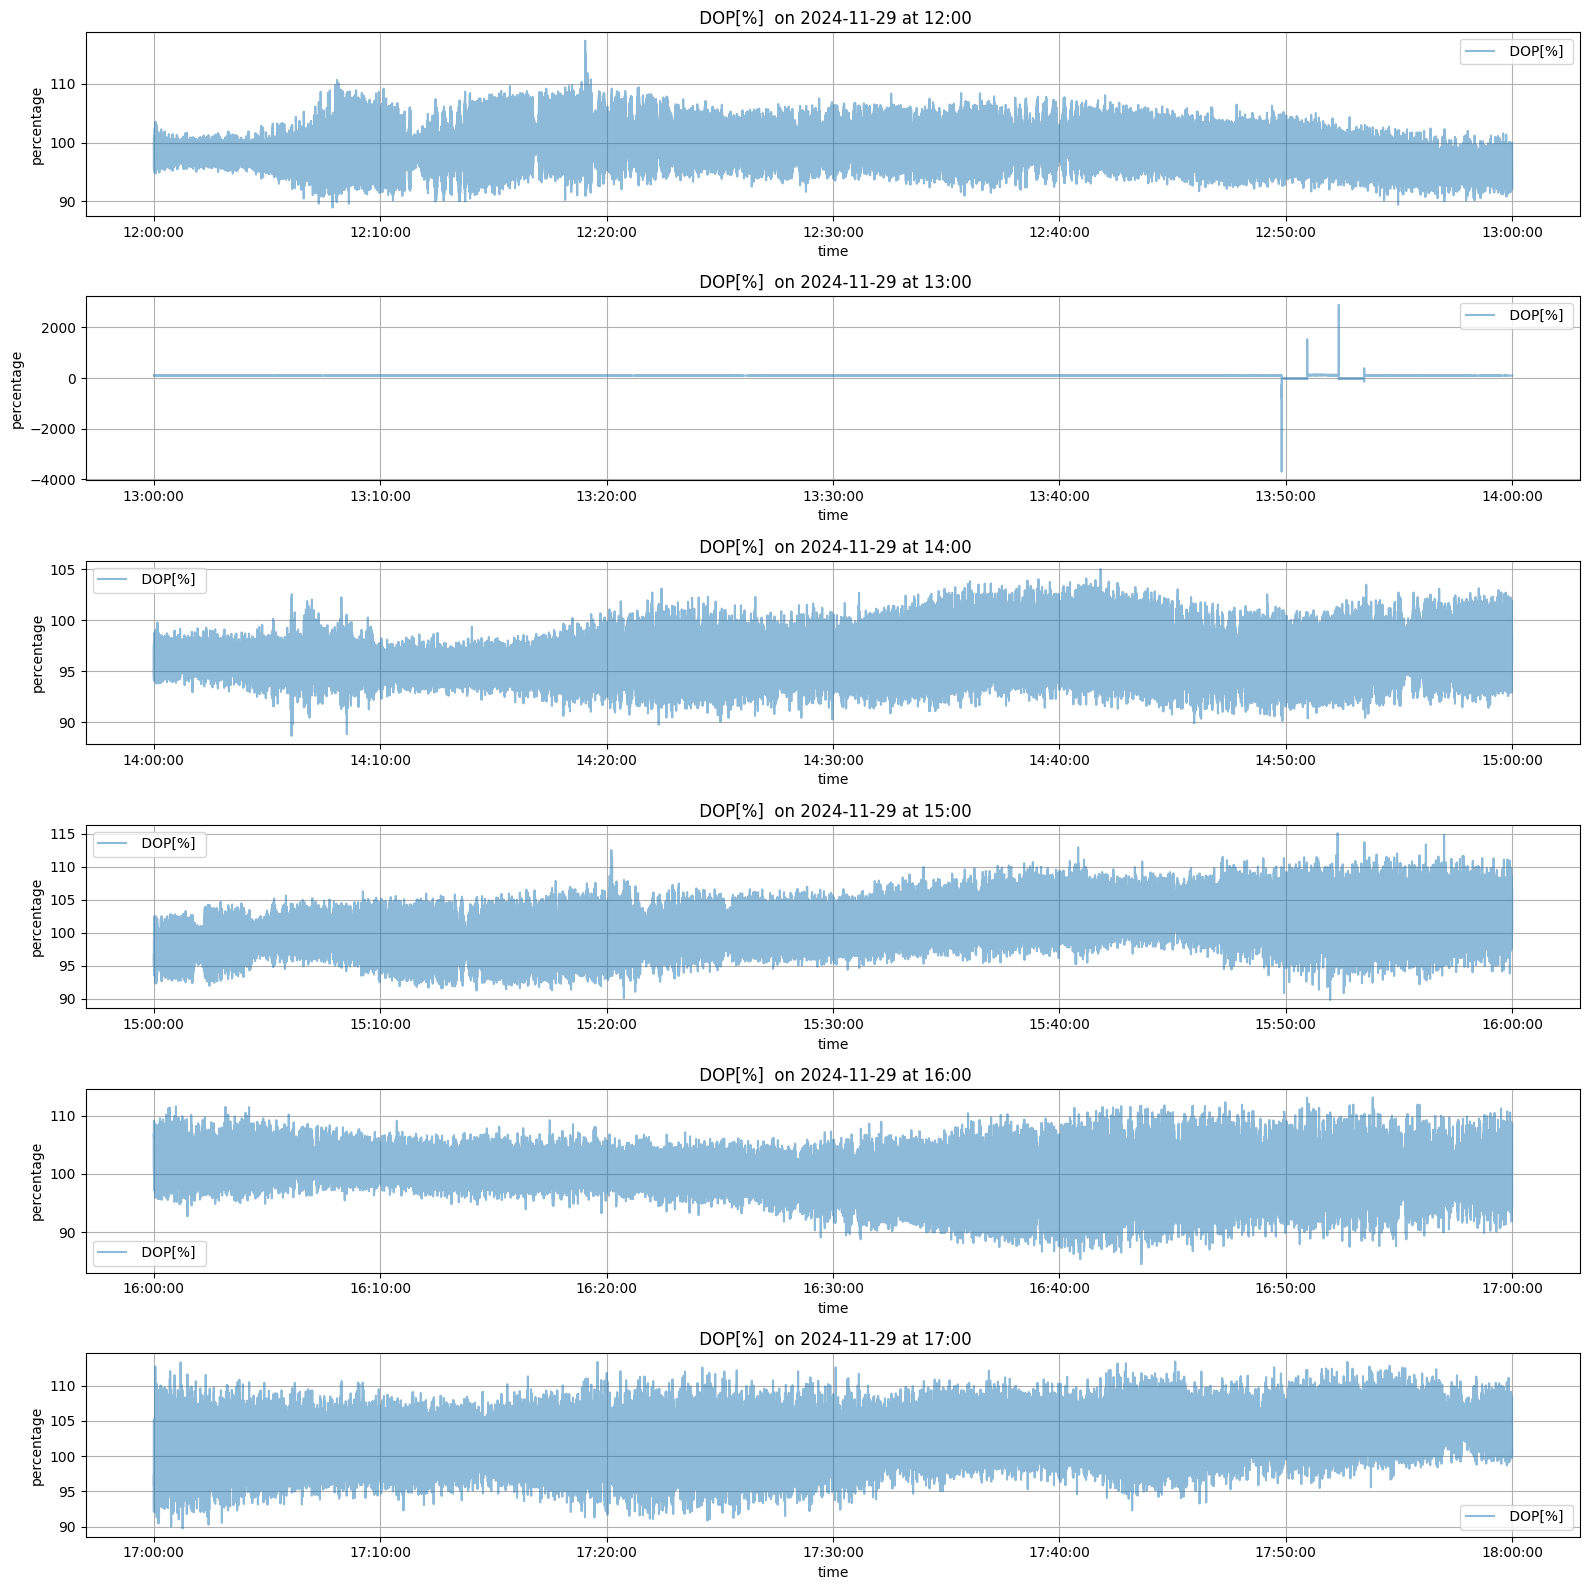

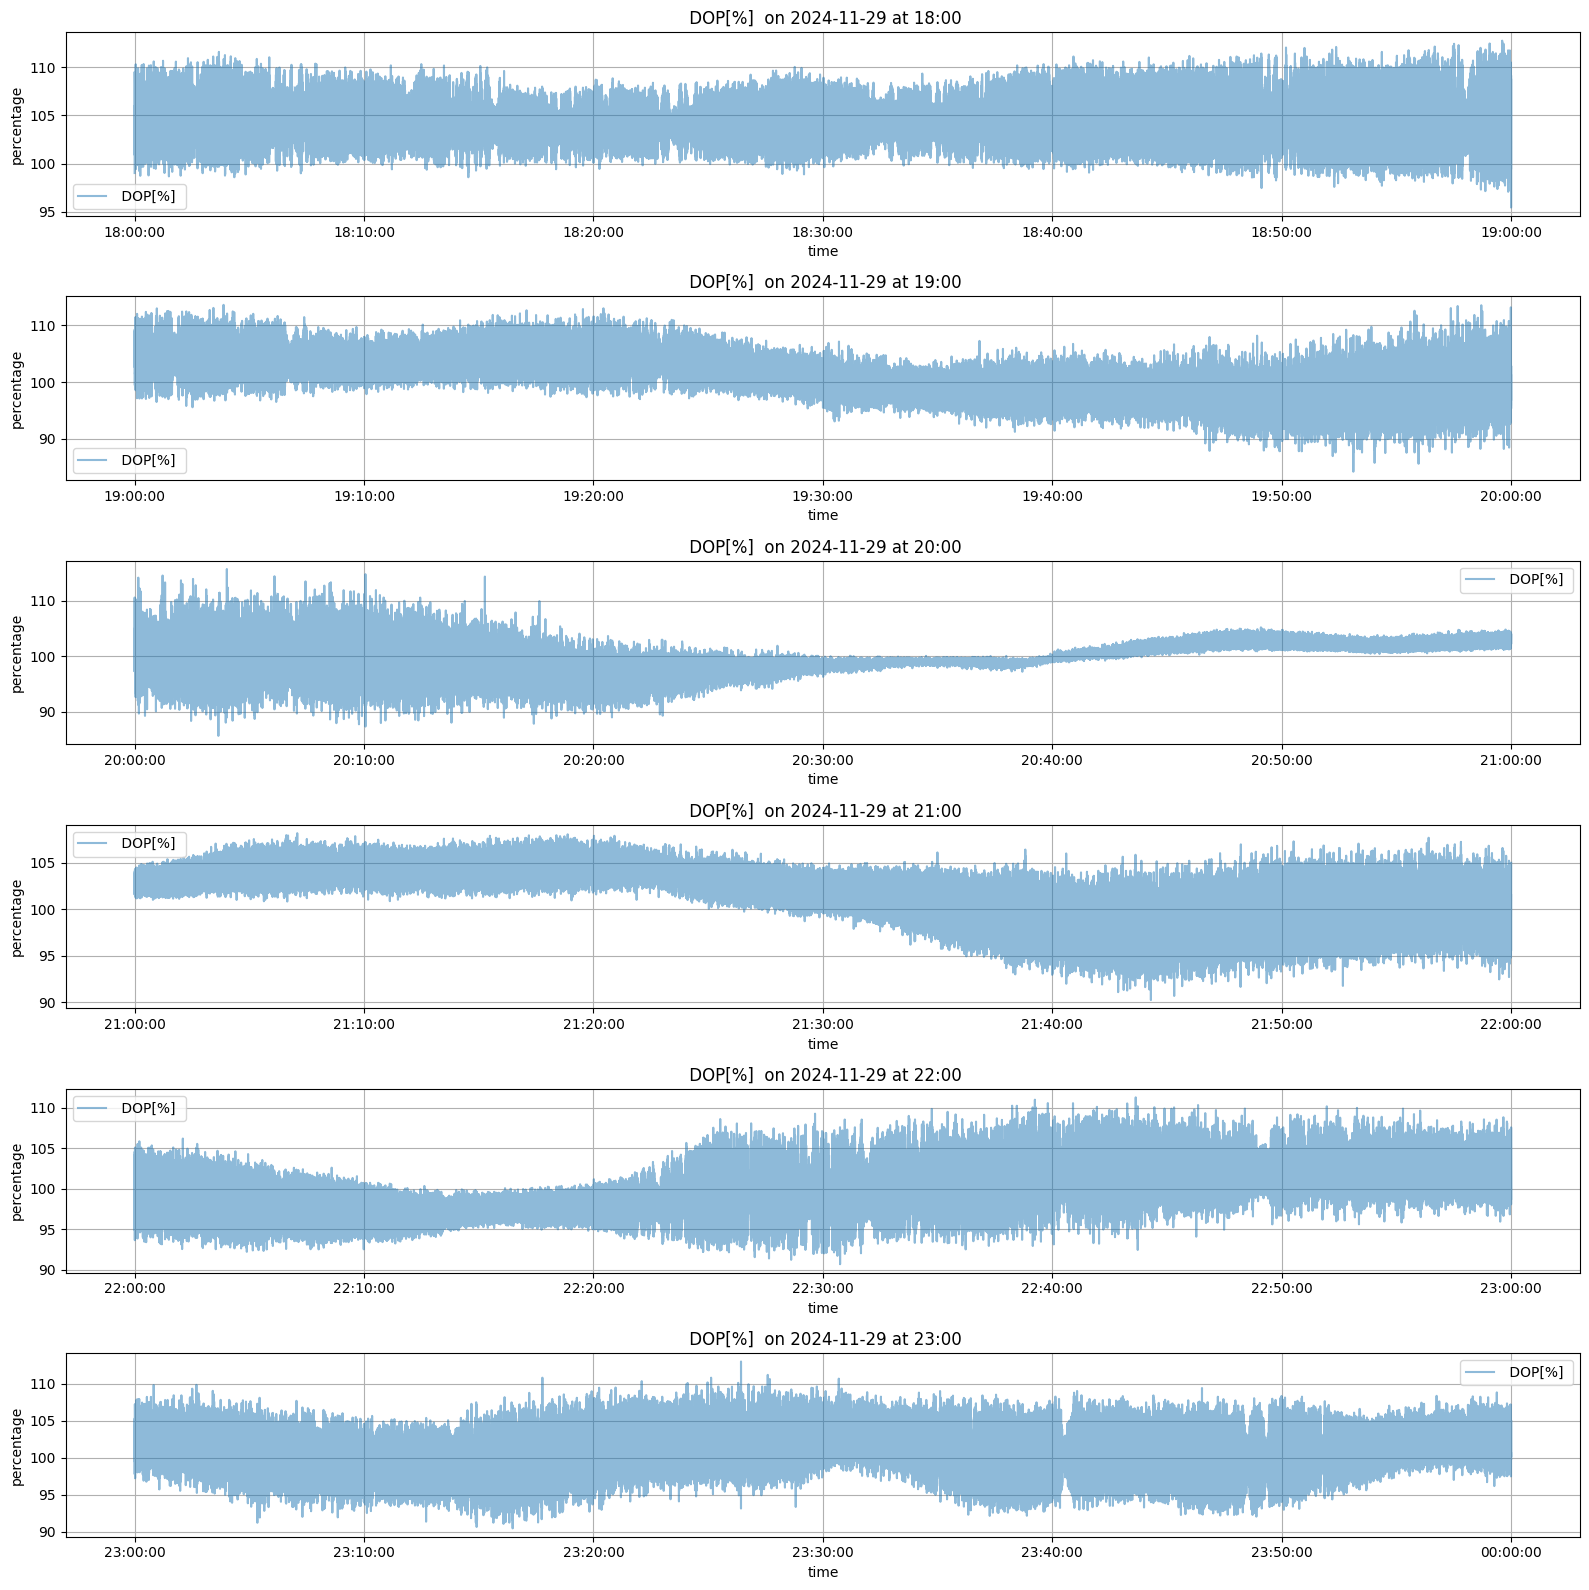

In [21]:
daily_quaters = [degree_hourly[:6], degree_hourly[6:12], degree_hourly[12:18], degree_hourly[18:]]
for quater in daily_quaters:
    fig, axs = plt.subplots(len(quater), 1, figsize=(16, 16), sharex=False)

    for i in range(len(quater)):
        ax = axs[i] if len(quater) > 1 else axs
        df_day = quater[i][1]

        ax.plot(df_day.index, df_day, label=columns[11], color=colors[day], alpha=0.5)
        ax.grid()
        ax.legend(loc='best')
        ax.set_title(f'{columns[11]} on {degree_daily_list[day][0]} at {quater[i][0]}:00')
        ax.set_xlabel('time')
        ax.set_ylabel('percentage')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    plt.tight_layout()
    plt.show()

## Ausreißerbereinigung

In [22]:
new_degree = degree[columns[11]]
new_degree = new_degree.drop(new_degree[(new_degree > 140) | (new_degree < 0)].index)
new_degree.describe()

count    7.088521e+06
mean     9.974852e+01
std      3.296249e+00
min      7.314000e+01
25%      9.738000e+01
50%      9.950000e+01
75%      1.021600e+02
max      1.350300e+02
Name:  DOP[%] , dtype: float64

In [23]:
new_degree_daily = new_degree.groupby(new_degree.index.date)
new_degree_daily_list = list(new_degree_daily)

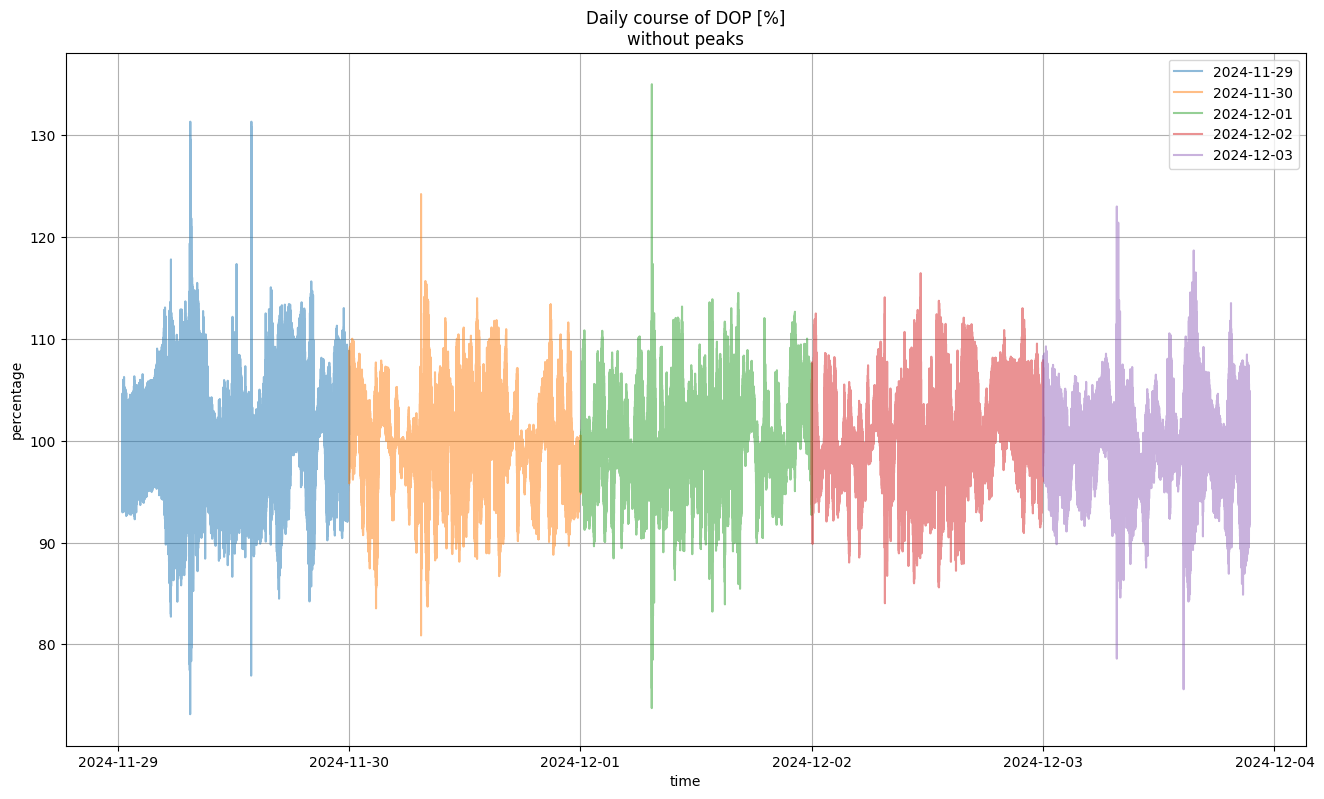

In [24]:
plt.figure(figsize = (16,9))
for date, df_day in new_degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date), alpha = 0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

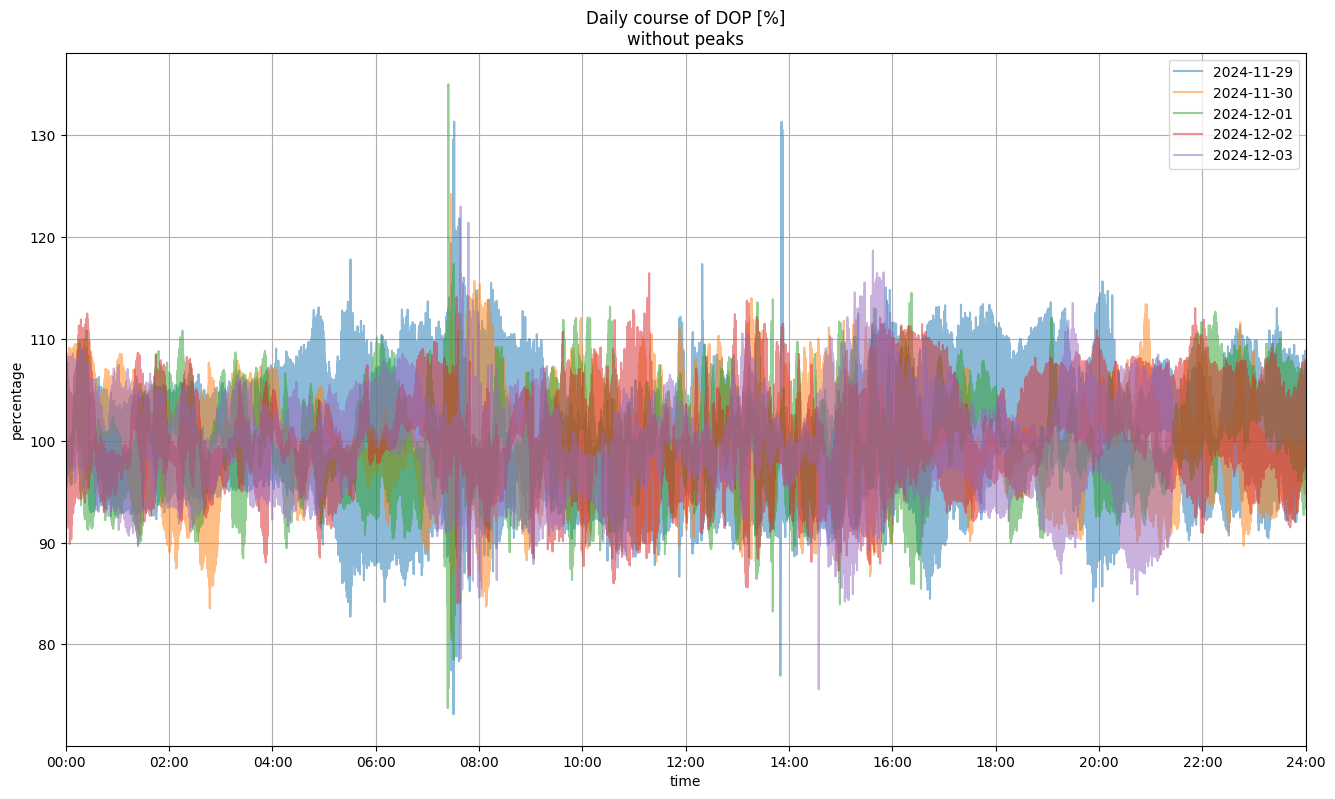

In [25]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Tägliche Normalverteilung mit Histogramm

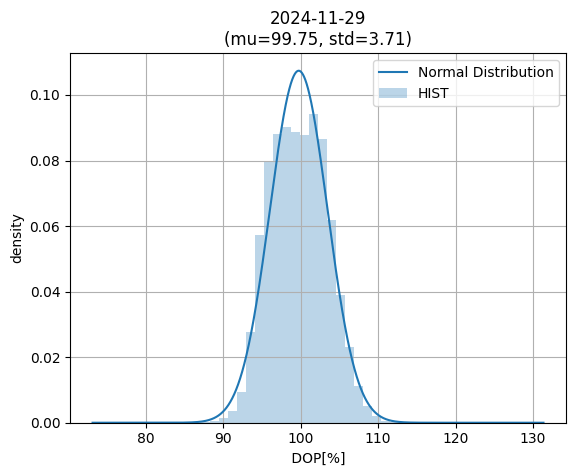

In [26]:
ydata1 = np.array(new_degree_daily_list[day][1])
mu1 = np.mean(ydata1)
sigma1 = np.std(ydata1)
x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
y1 = norm.pdf(x1, mu1, sigma1)  

plt.plot(x1, y1, label = 'Normal Distribution', color=colors[day])
plt.hist(ydata1, bins = 50, density = True, color=colors[day], alpha = 0.3, label = "HIST")

plt.title(f'{new_degree_daily_list[day][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

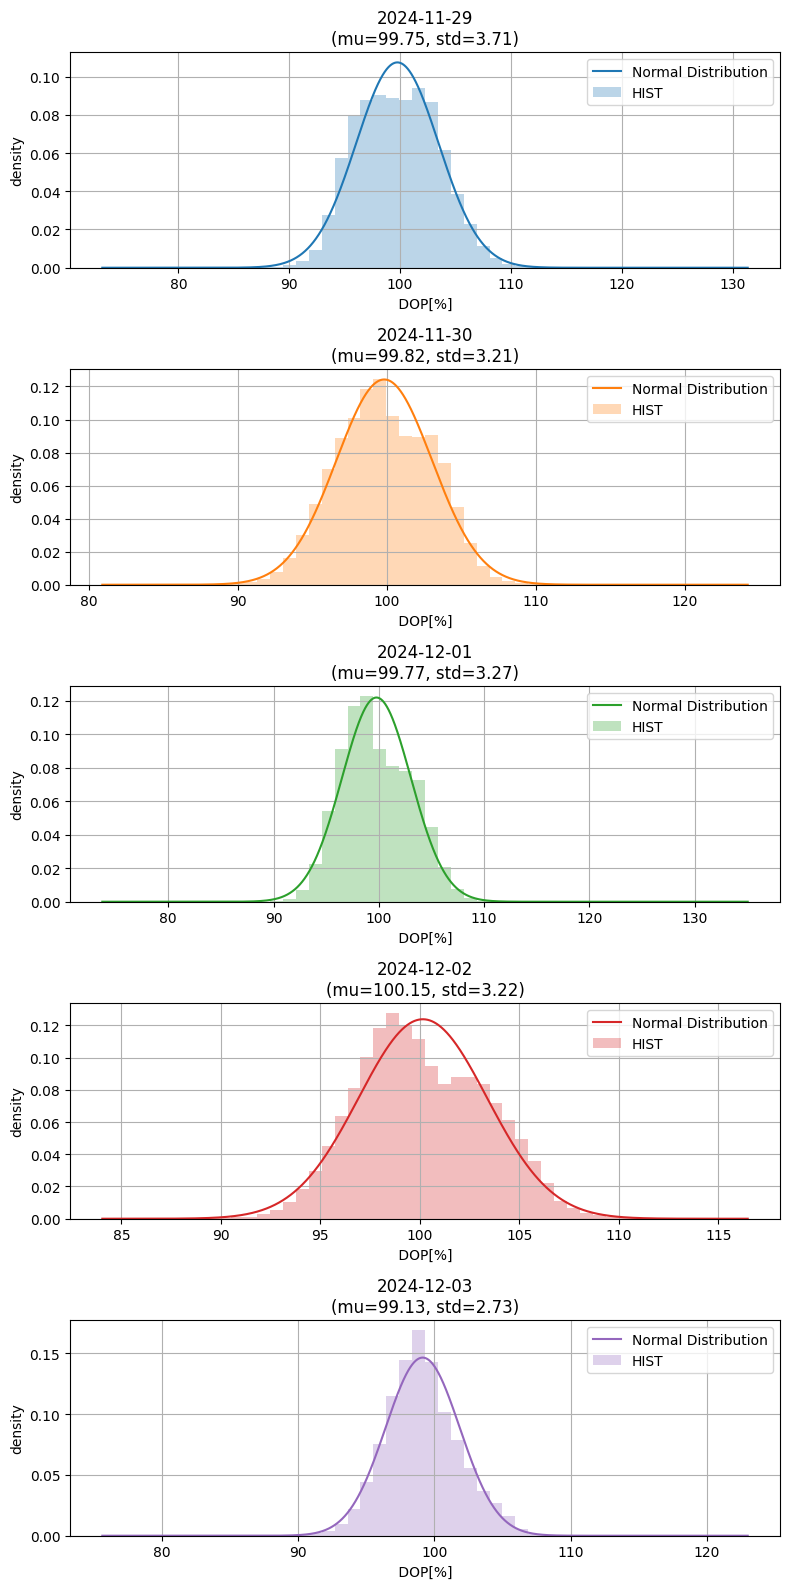

In [27]:
fig, axs = plt.subplots(len(new_degree_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(new_degree_daily_list)):
    ax = axs[i] if len(new_degree_daily_list) > 1 else axs
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{degree_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[11])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

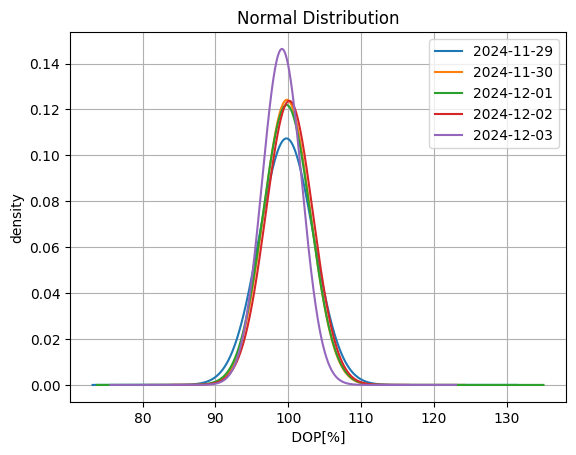

In [28]:
for i in range(len(new_degree_daily_list)):
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    plt.plot(x1, y1, label = new_degree_daily_list[i][0])
    
plt.title(f'Normal Distribution')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

## Filterung mittels Tief- und Hochpass

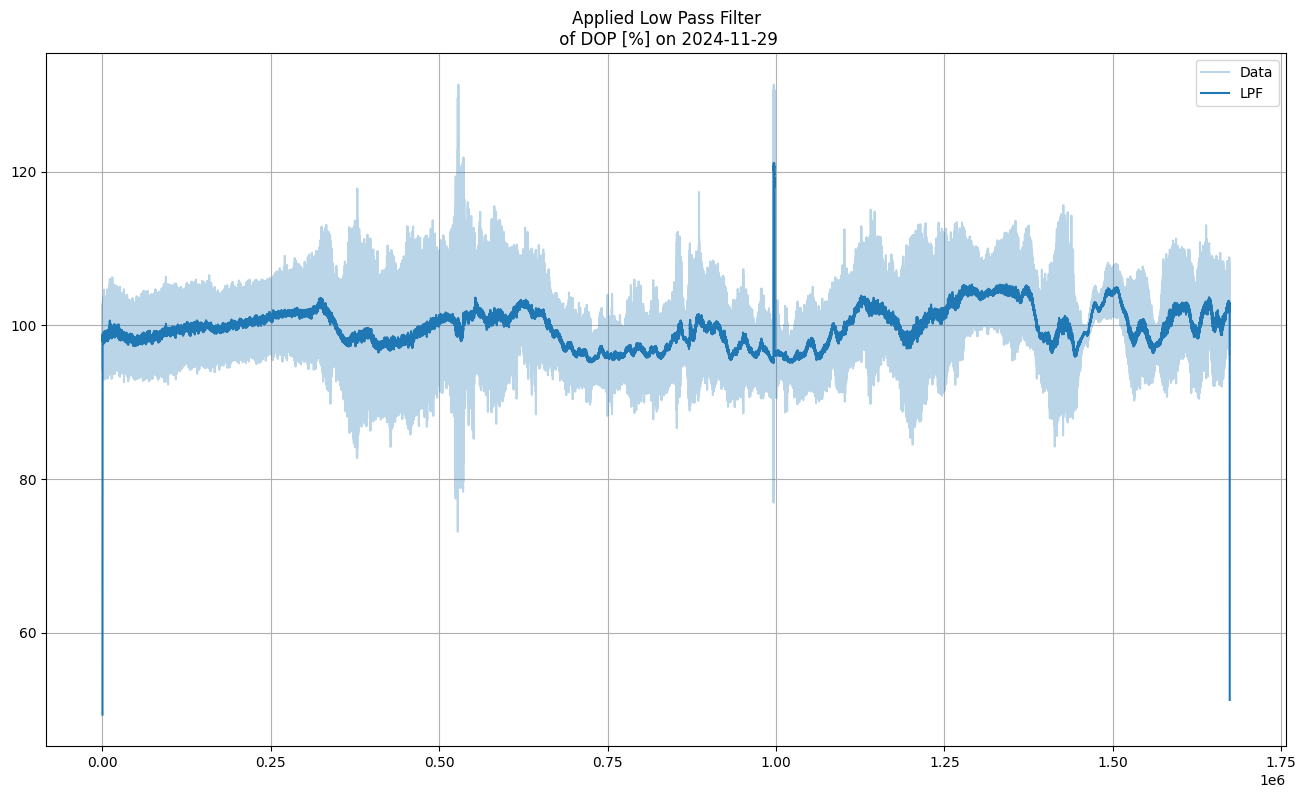

In [29]:
ydata = np.array(new_degree_daily_list[day][1])

lps = lowpass(ydata, 100)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of DOP [%] on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

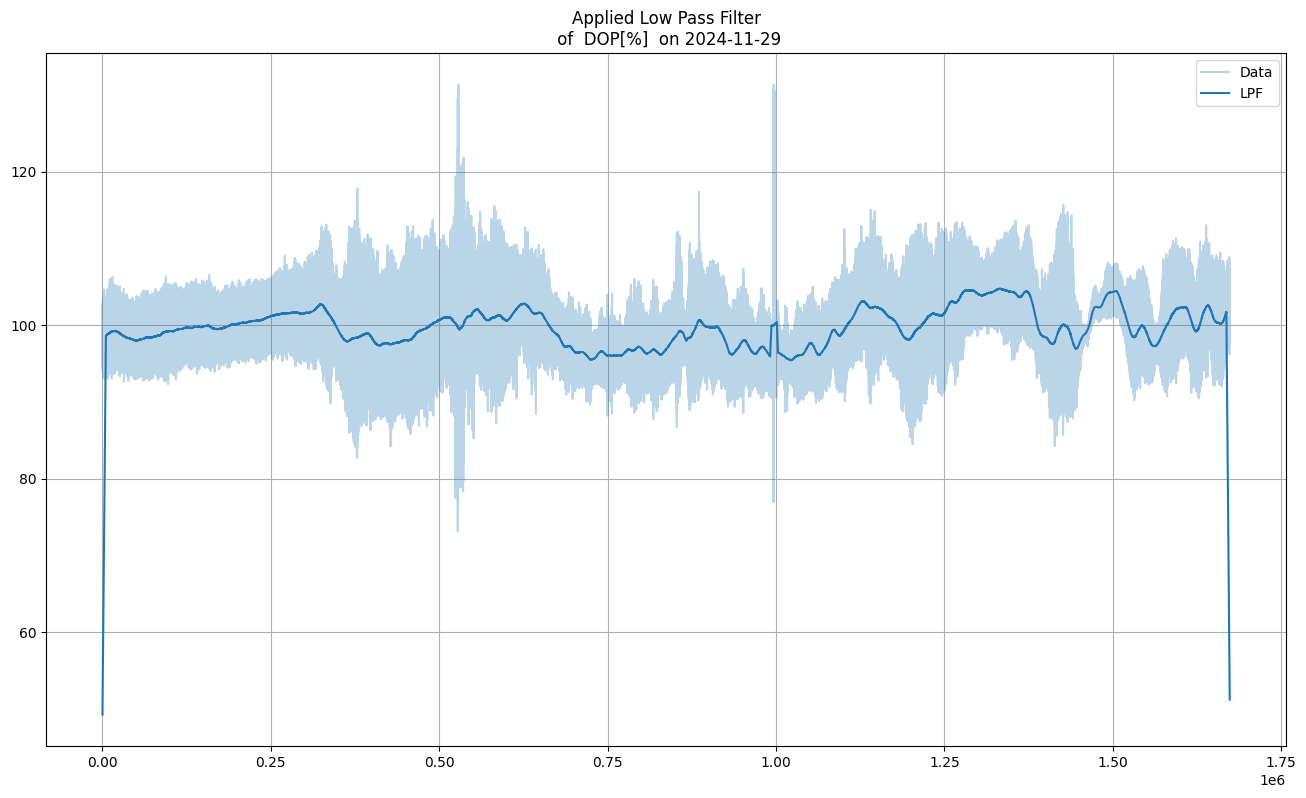

In [30]:
ydata = np.array(new_degree_daily_list[day][1])

lps = lowpass(ydata, 10000)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

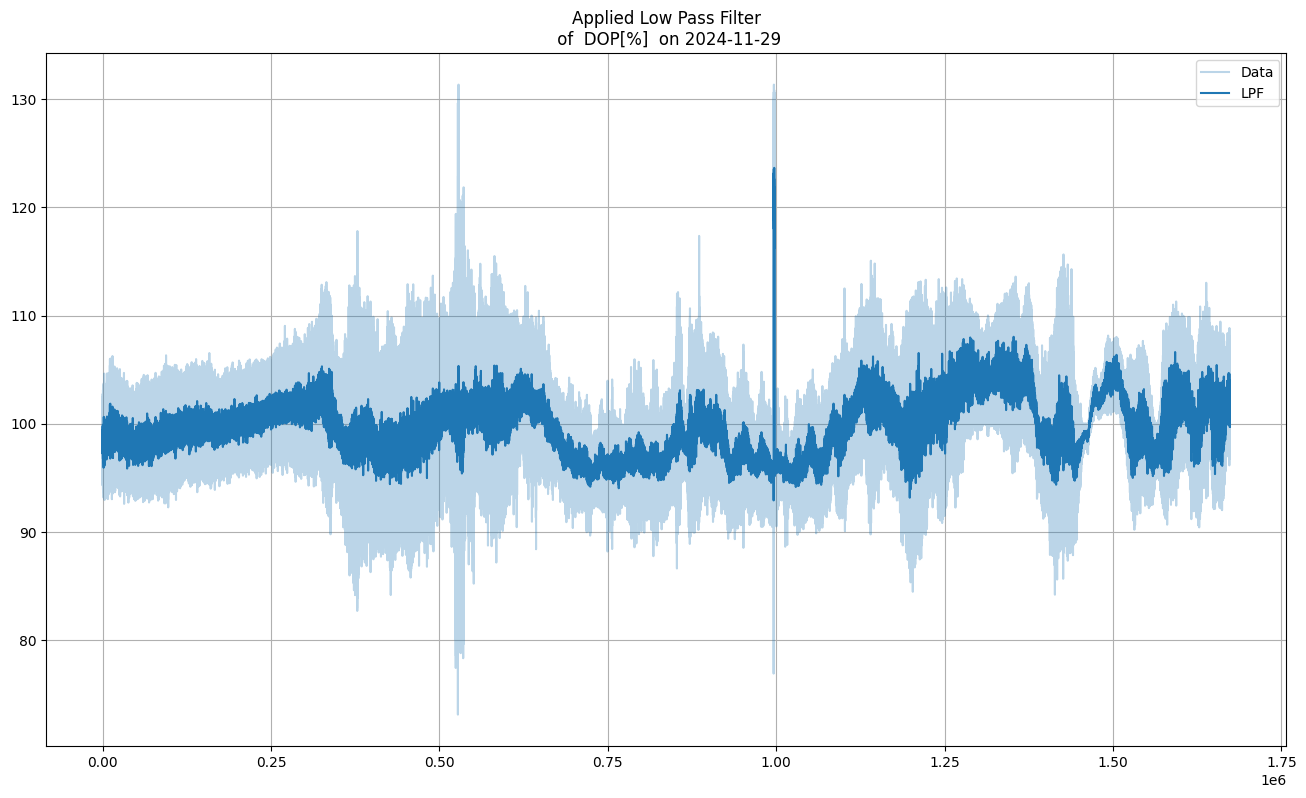

In [32]:
cutoff = 1.0
btype='low'

ydata = np.array(new_degree_daily_list[day][1])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

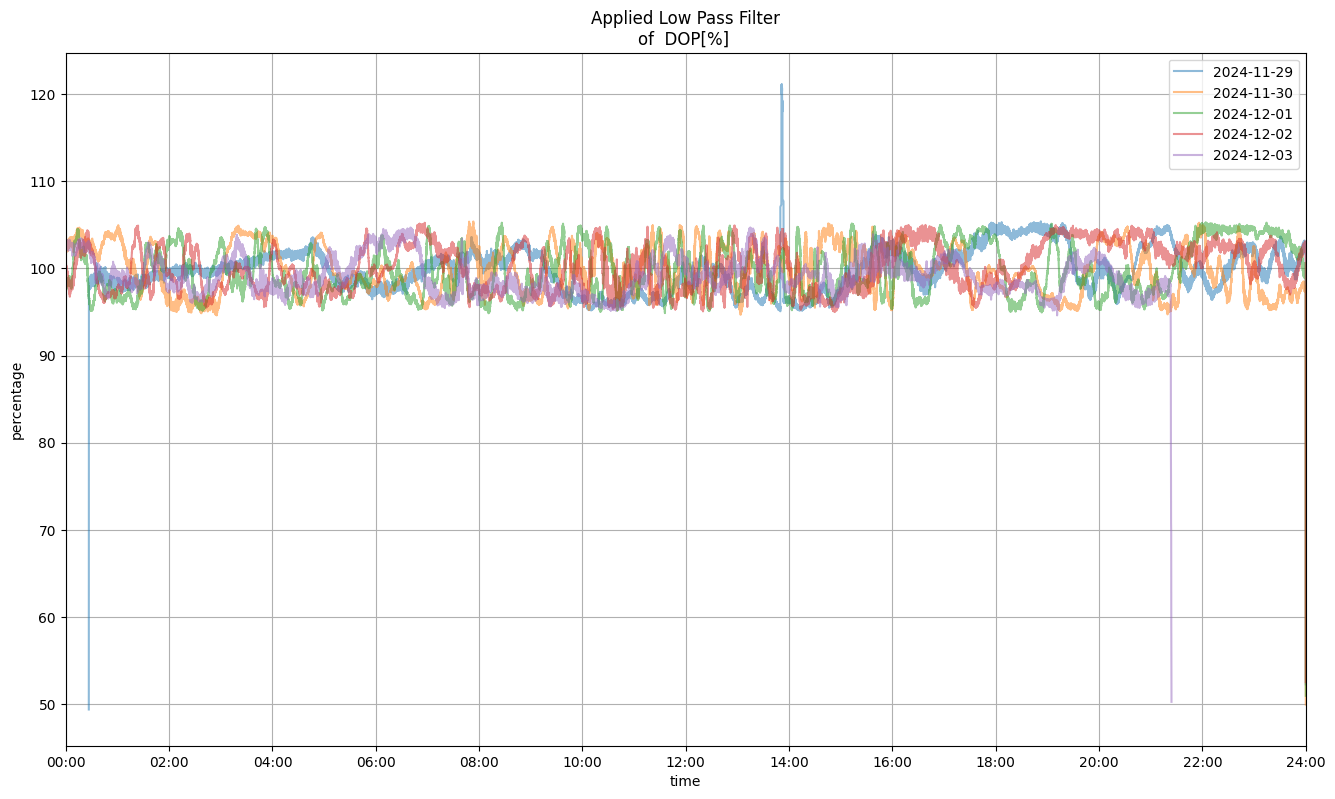

In [33]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

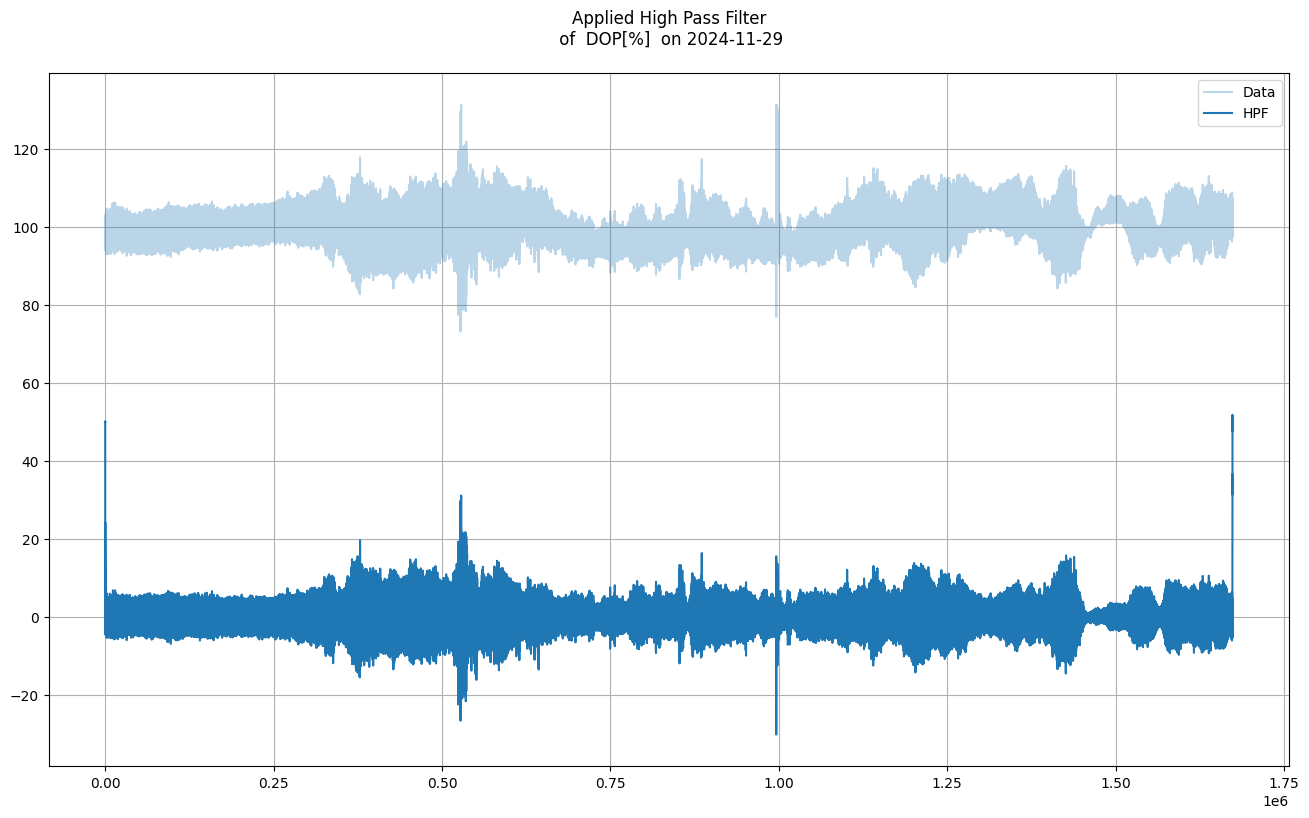

In [34]:
ydata = np.array(new_degree_daily_list[day][1])

hps = highpass(ydata, 100)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color=colors[day], alpha=0.3)
plt.plot(hps, label = 'HPF', color=colors[day])
plt.title(f'Applied High Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}\n')
plt.grid()
plt.legend(loc = 'best')
plt.show()

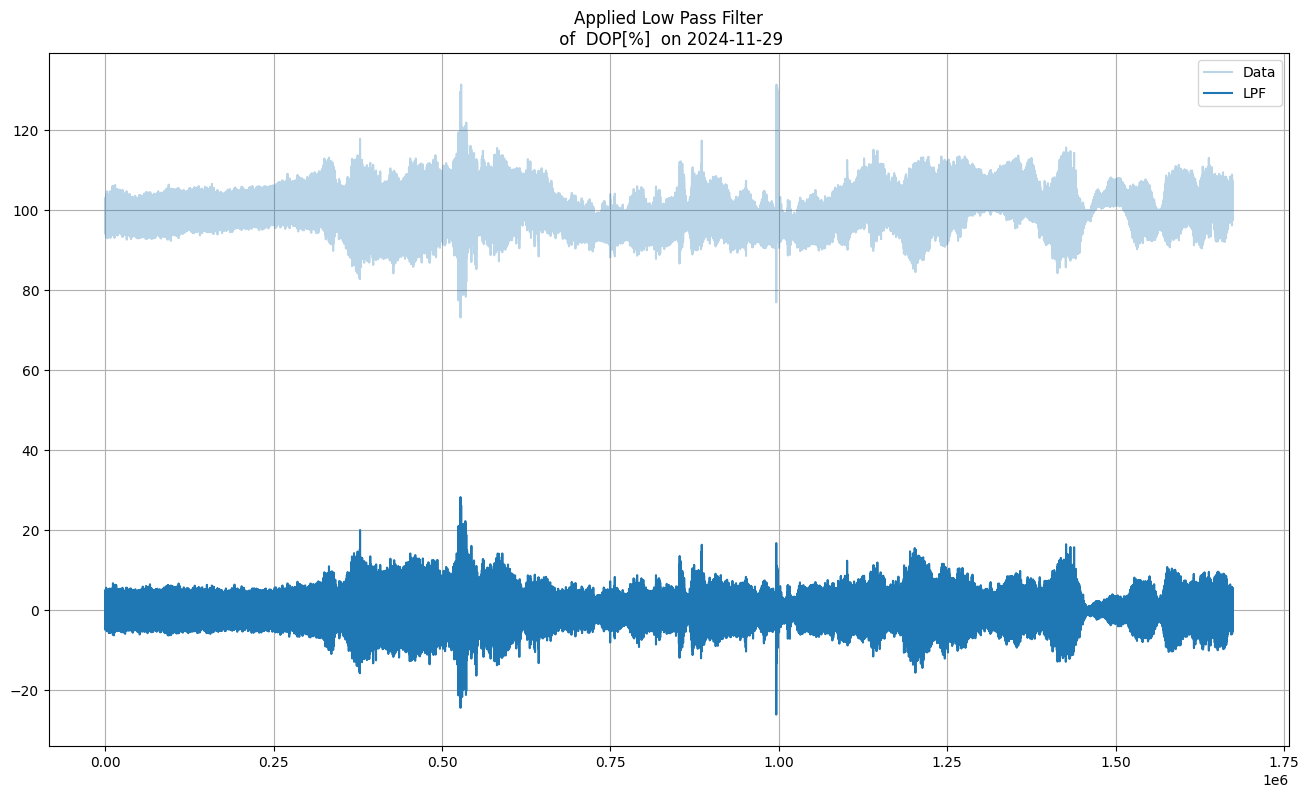

In [36]:
cutoff = 1.0
btype='high'

ydata = np.array(new_degree_daily_list[day][1])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)
plt.figure(figsize = (16,9))
plt.plot(ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(lps, label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter\n of {columns[11]} on {new_degree_daily_list[day][0]}')
plt.grid()
plt.legend(loc = 'best')
plt.show()

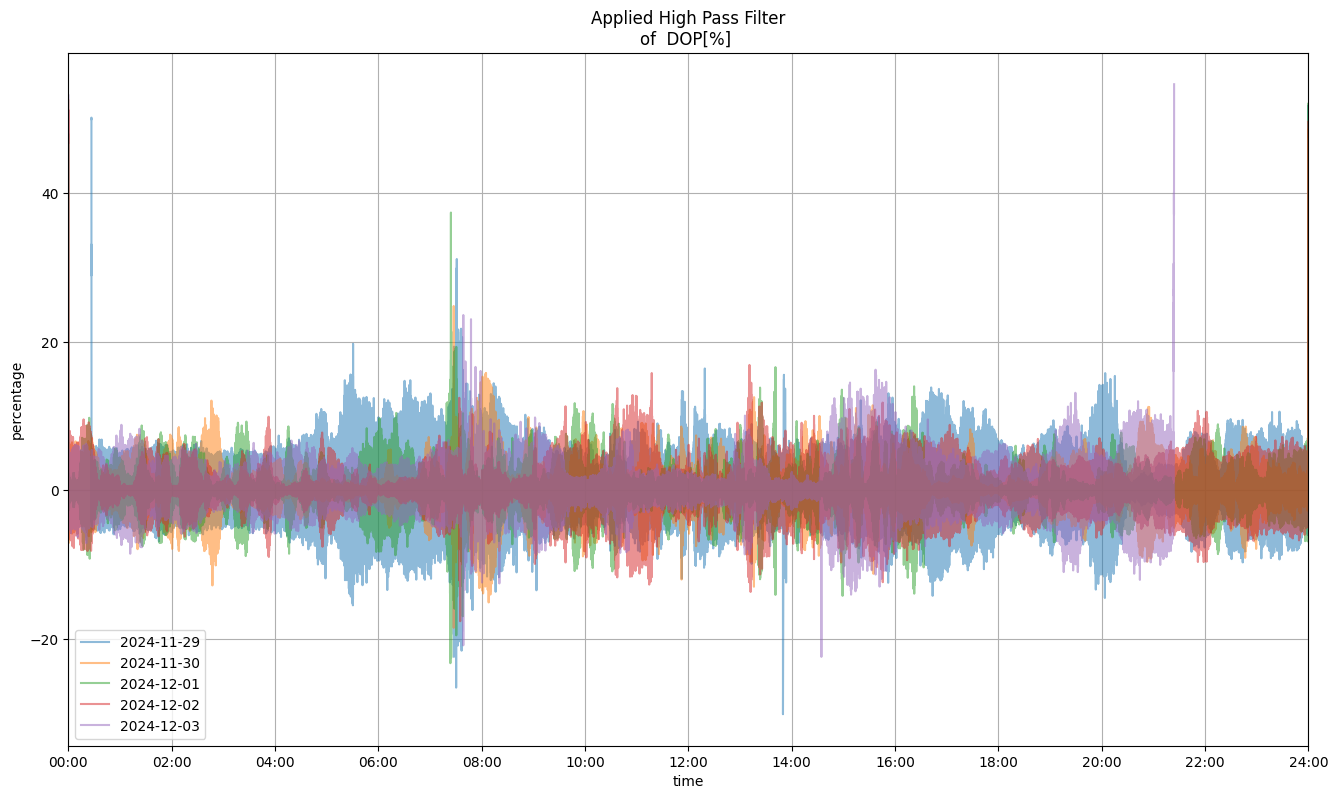

In [35]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)
    plt.plot(times, hps, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter\nof {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

# Winkelparameter (Azimut [°], Elliptizität [°])

In [37]:
angle = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[9], columns[10]])

In [38]:
angle[columns[0]] = pd.to_datetime(angle[columns[0]])
angle.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [39]:
angle_daily = angle.groupby(angle.index.date)
angle_daily_list = list(angle_daily)

In [40]:
for date, df_day in angle_daily_list:
    print(date, '\n')
    print(df_day.describe())
    print('')

2024-11-29 

        Azimuth[°]   Ellipticity[°] 
count  1.676194e+06     1.676194e+06
mean   5.728160e+00    -1.144504e+00
std    2.365813e+01     1.490541e+01
min   -9.000000e+01    -4.468000e+01
25%   -5.880000e+00    -1.364000e+01
50%    6.930000e+00     1.240000e+00
75%    2.023000e+01     1.106000e+01
max    9.000000e+01     4.454000e+01

2024-11-30 

        Azimuth[°]   Ellipticity[°] 
count  1.500099e+06     1.500099e+06
mean   2.428019e+00     1.063311e+00
std    5.500757e+01     1.903680e+01
min   -9.000000e+01    -4.497000e+01
25%   -4.778000e+01    -1.415000e+01
50%    8.700000e-01     1.020000e+00
75%    5.337000e+01     1.478000e+01
max    9.000000e+01     4.498000e+01

2024-12-01 

        Azimuth[°]   Ellipticity[°] 
count  1.429572e+06     1.429572e+06
mean   7.651423e+00    -2.963670e+00
std    5.176796e+01     1.858525e+01
min   -9.000000e+01    -4.496000e+01
25%   -3.570000e+01    -1.659000e+01
50%    9.750000e+00    -3.400000e+00
75%    5.514000e+01     9.940000e+

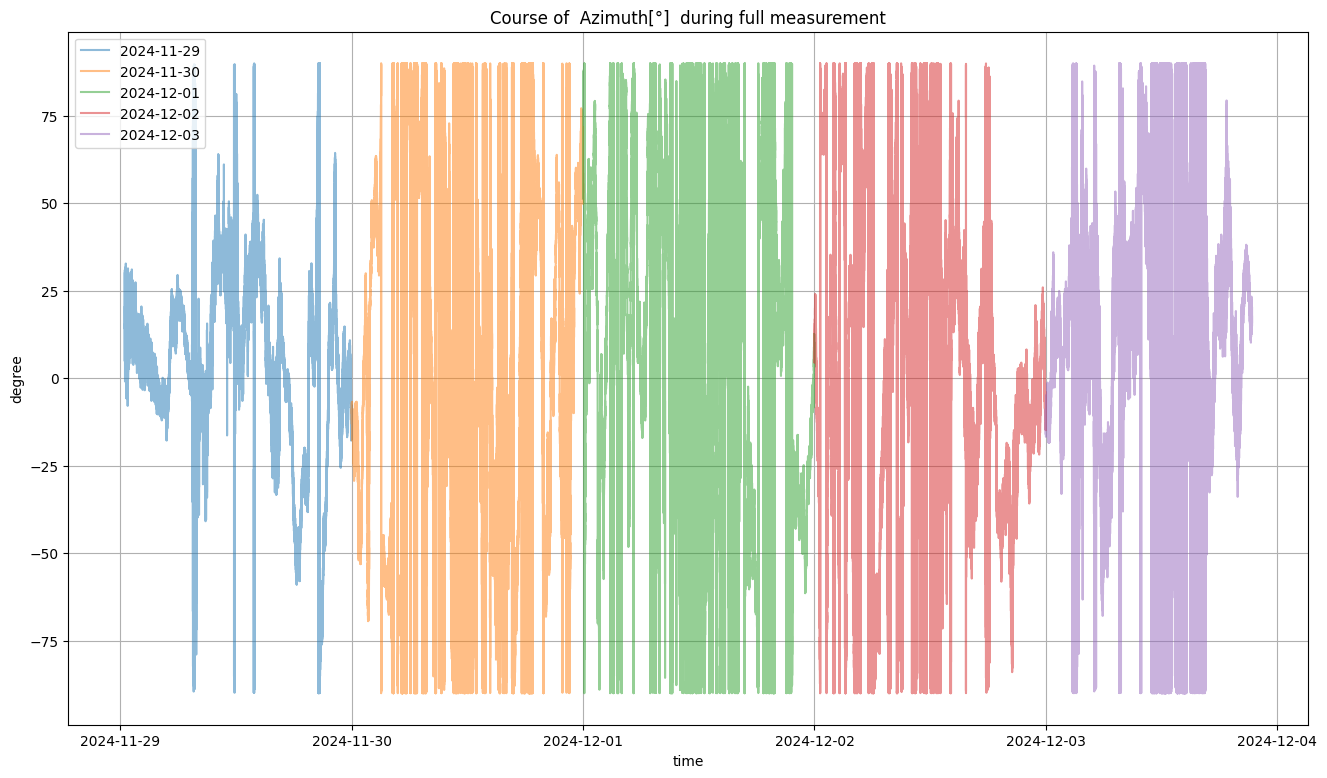

In [41]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[9]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[9]} during full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

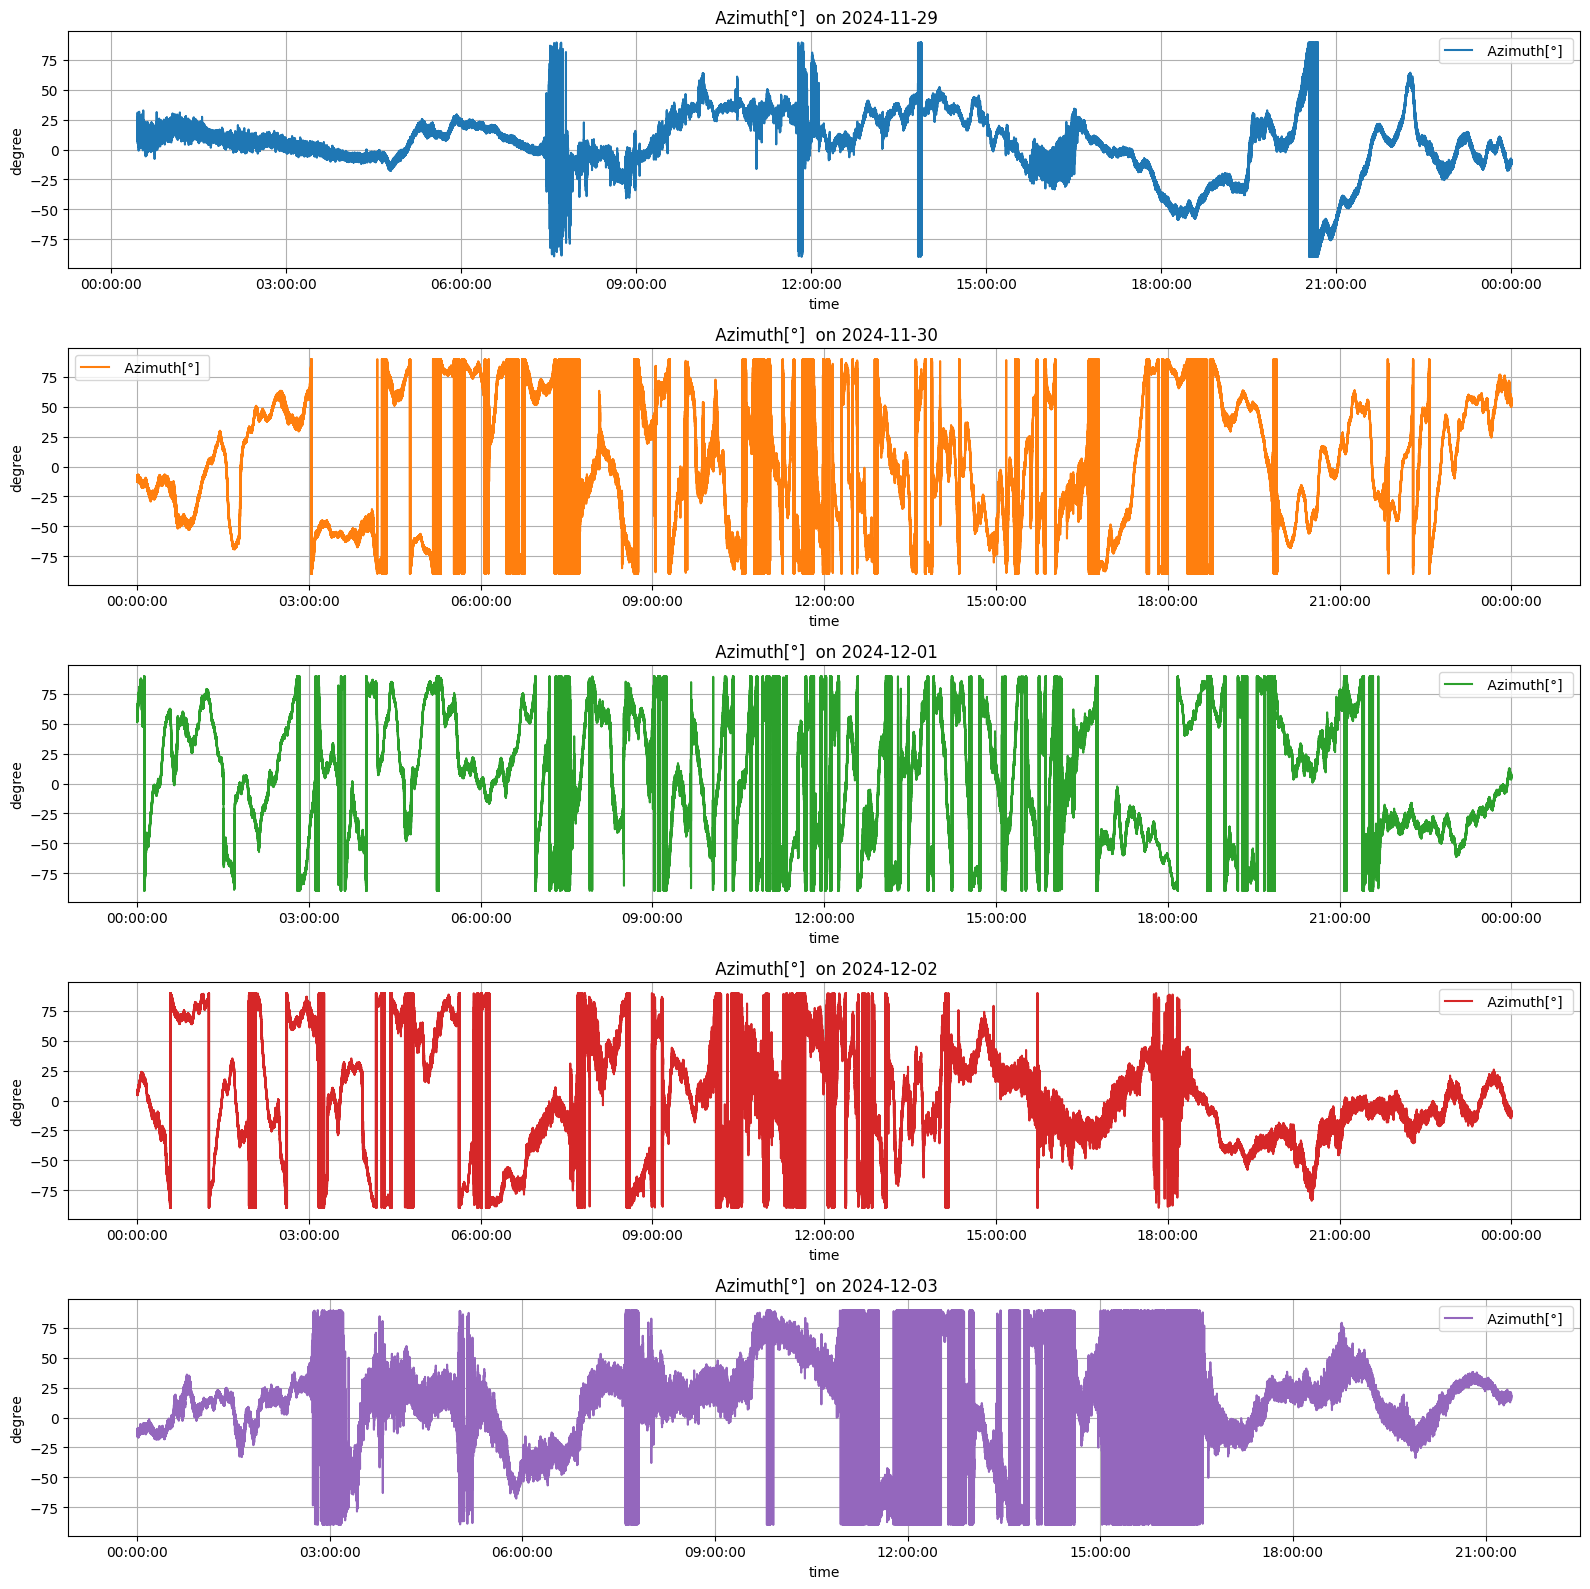

In [42]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]

    ax.plot(df_day.index, df_day, label=columns[9], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

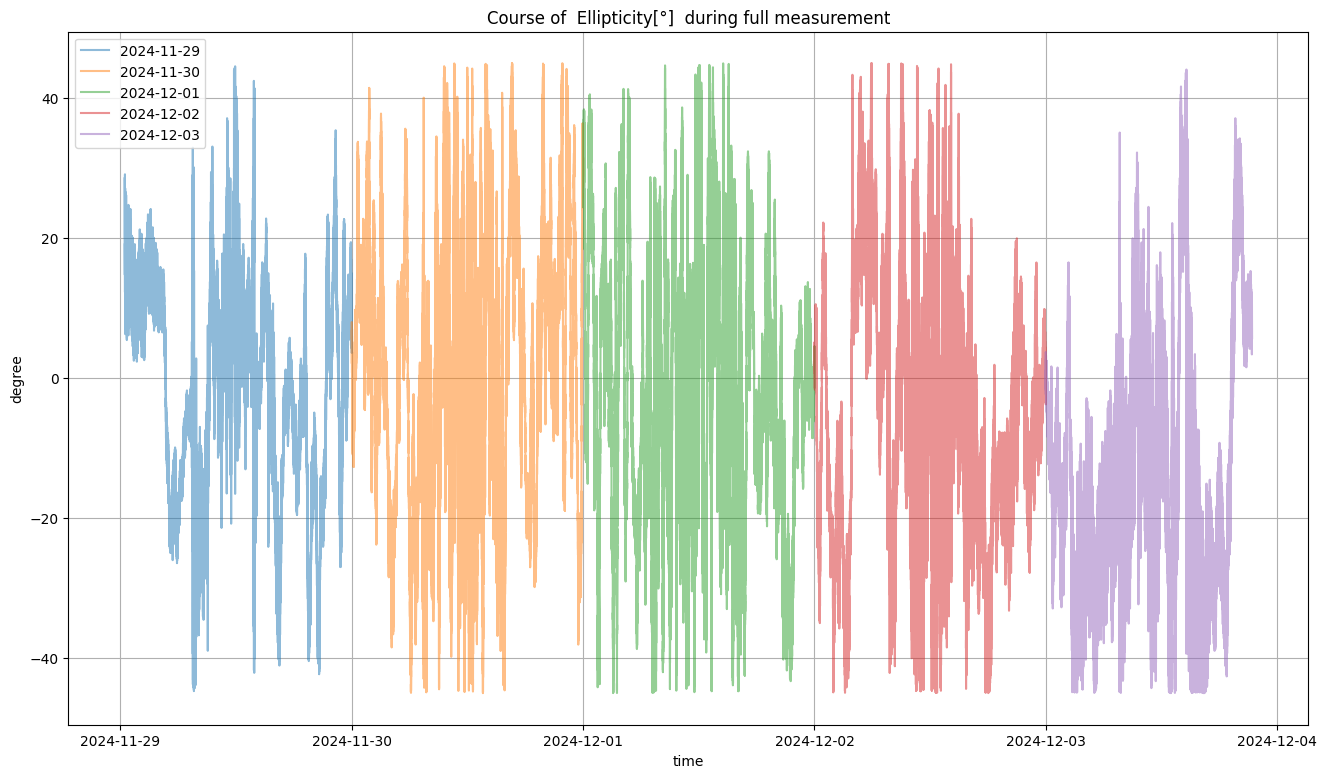

In [43]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[10]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[10]} during full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

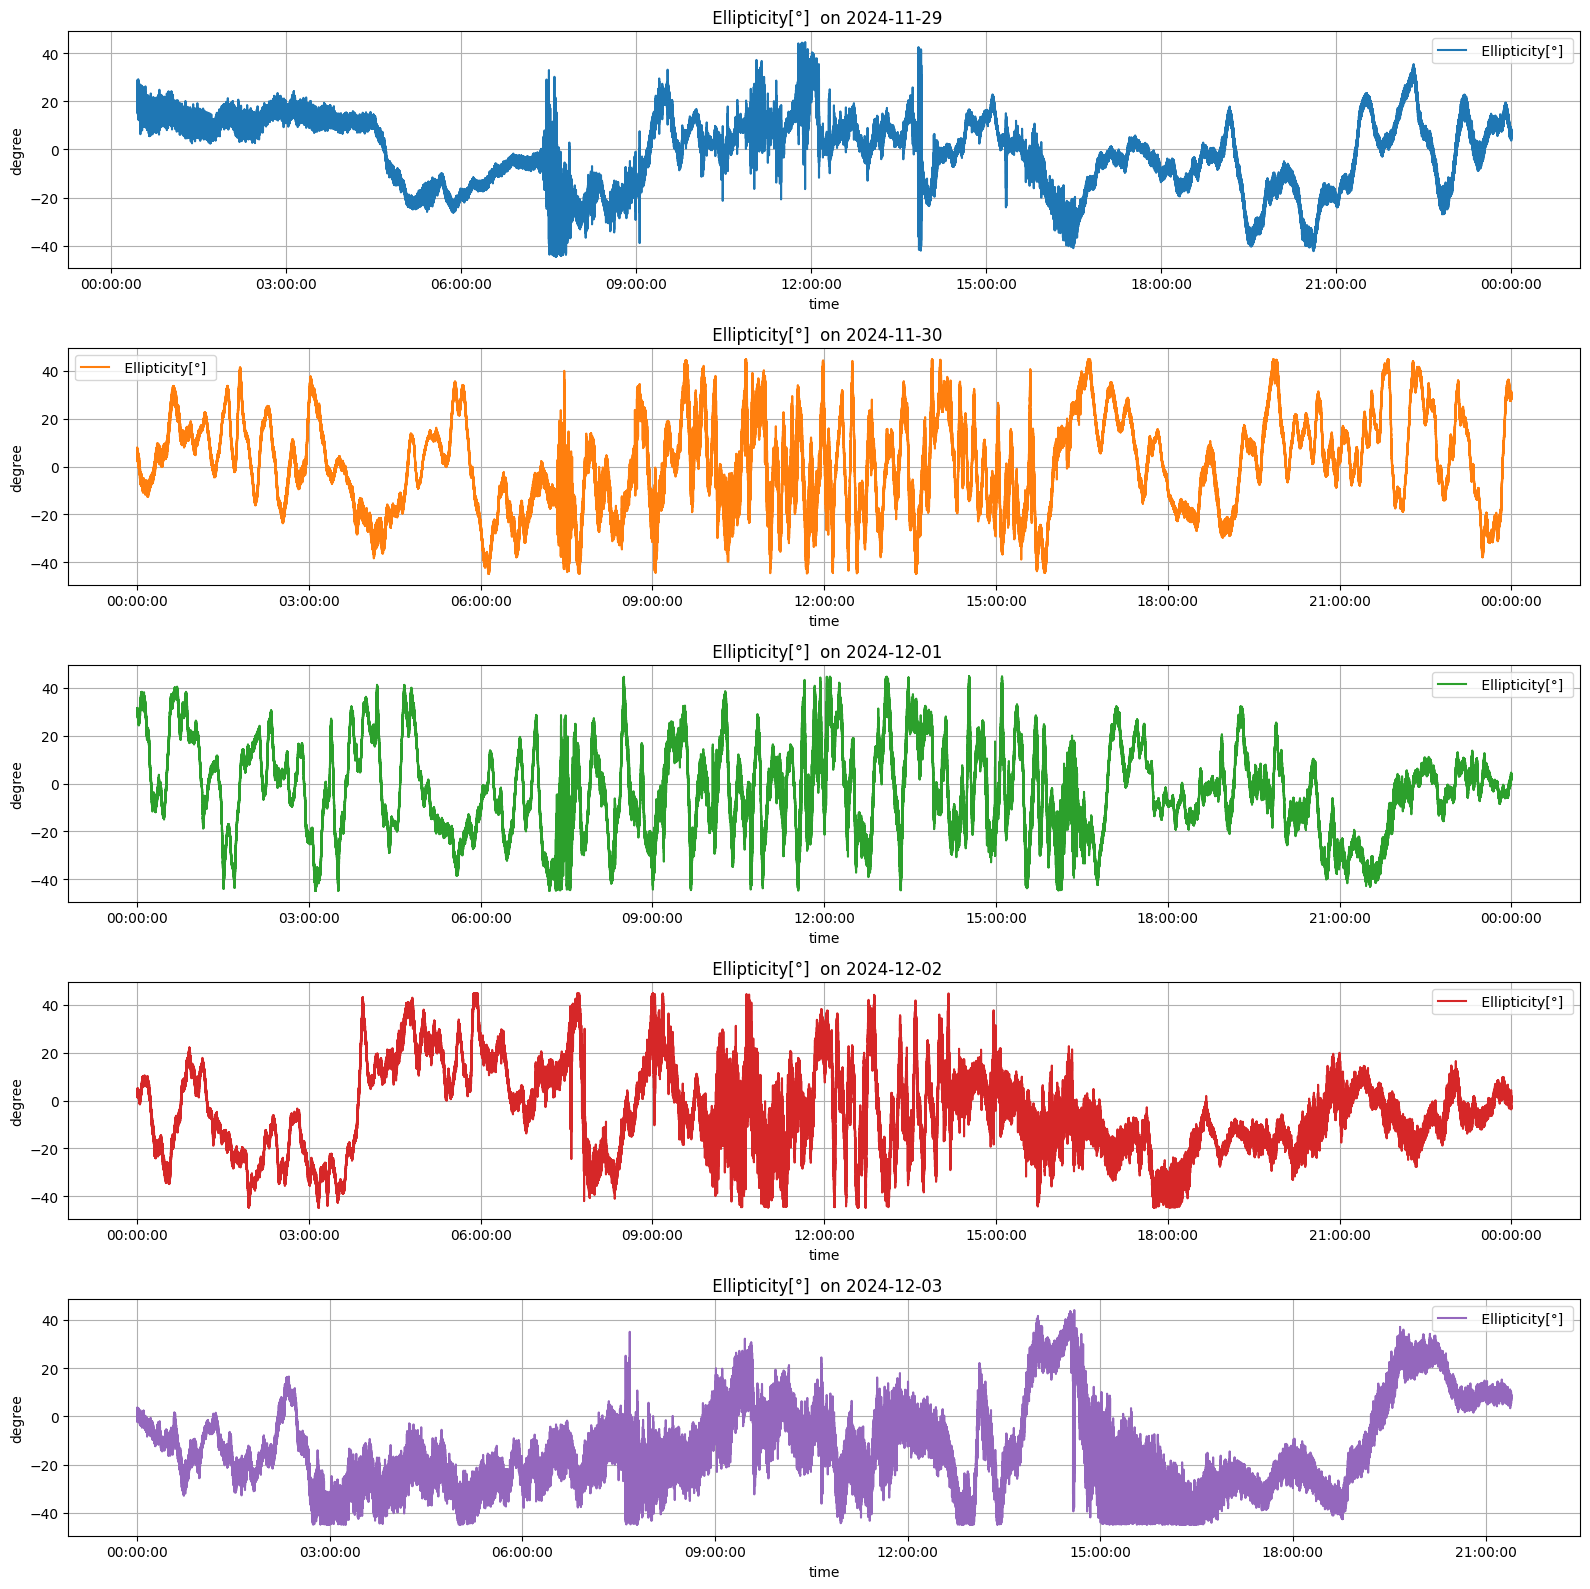

In [44]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]

    ax.plot(df_day.index, df_day, label=columns[10], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Tägliche Normalverteilung mit Histogramm

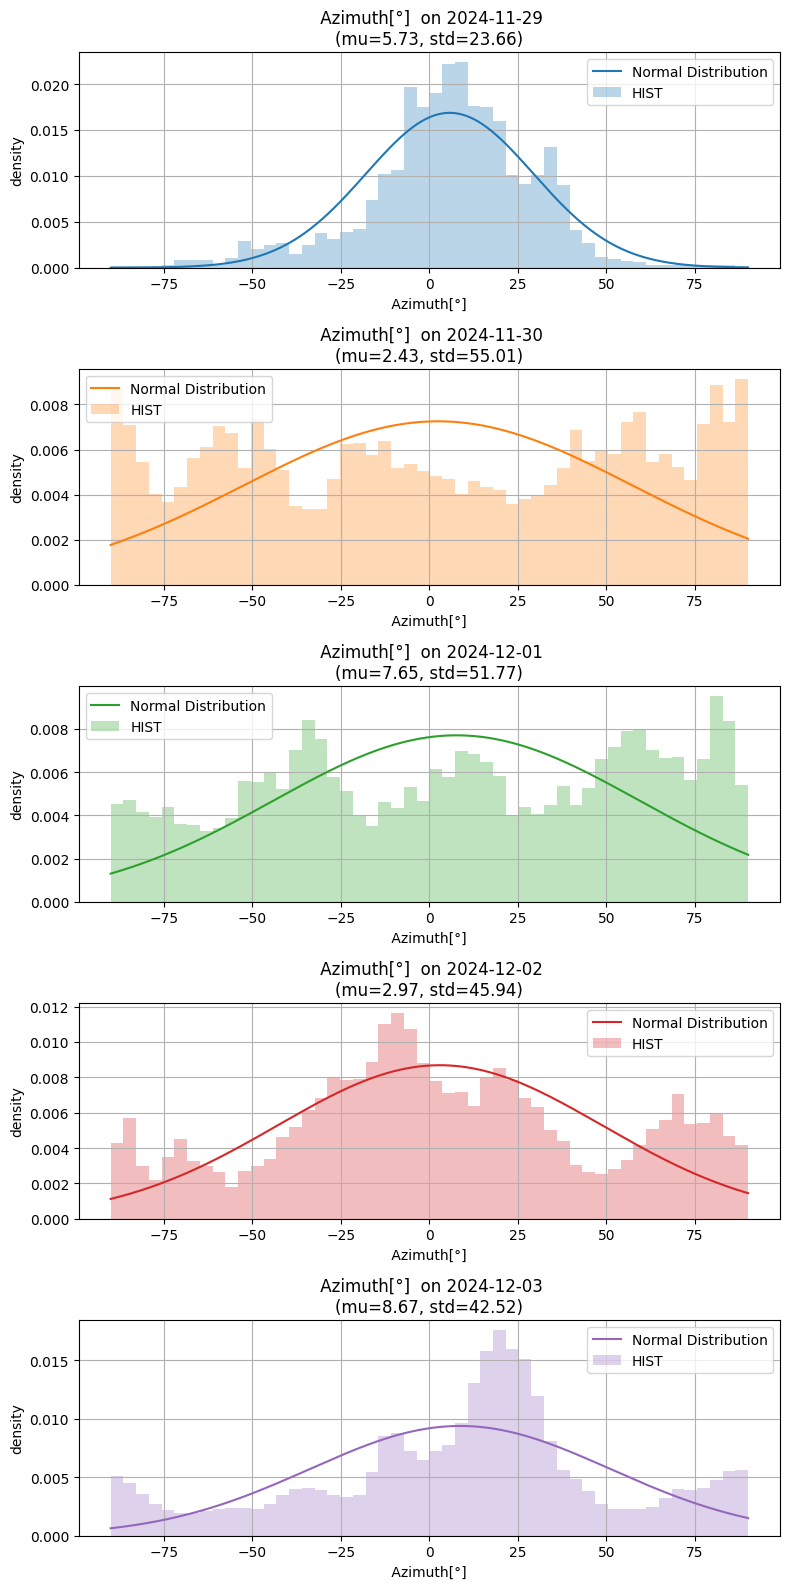

In [45]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[9]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[9])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

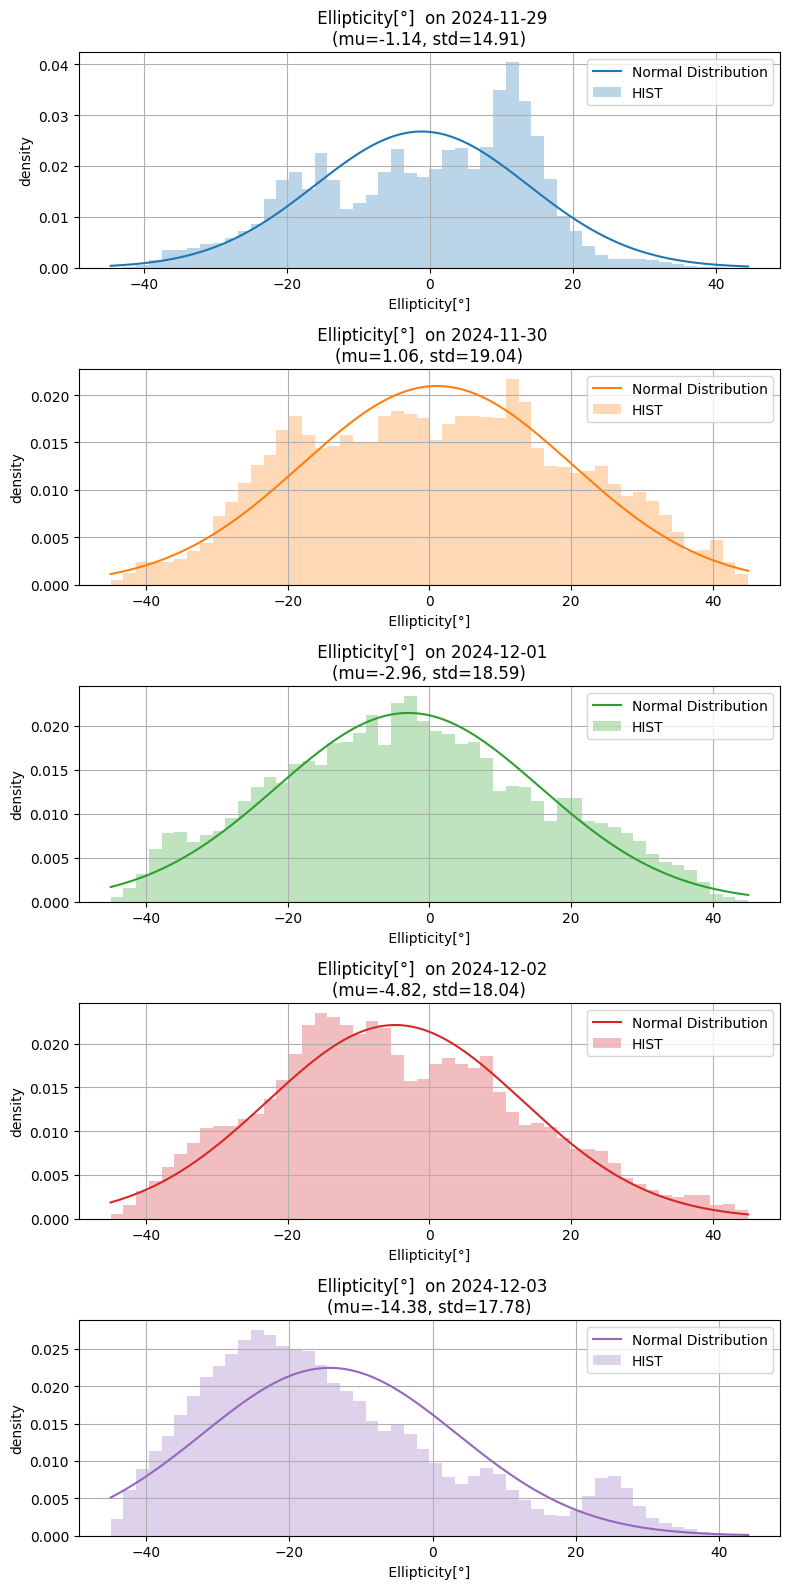

In [46]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[10]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[10])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

## Filterung mittels Tief- und Hochpass

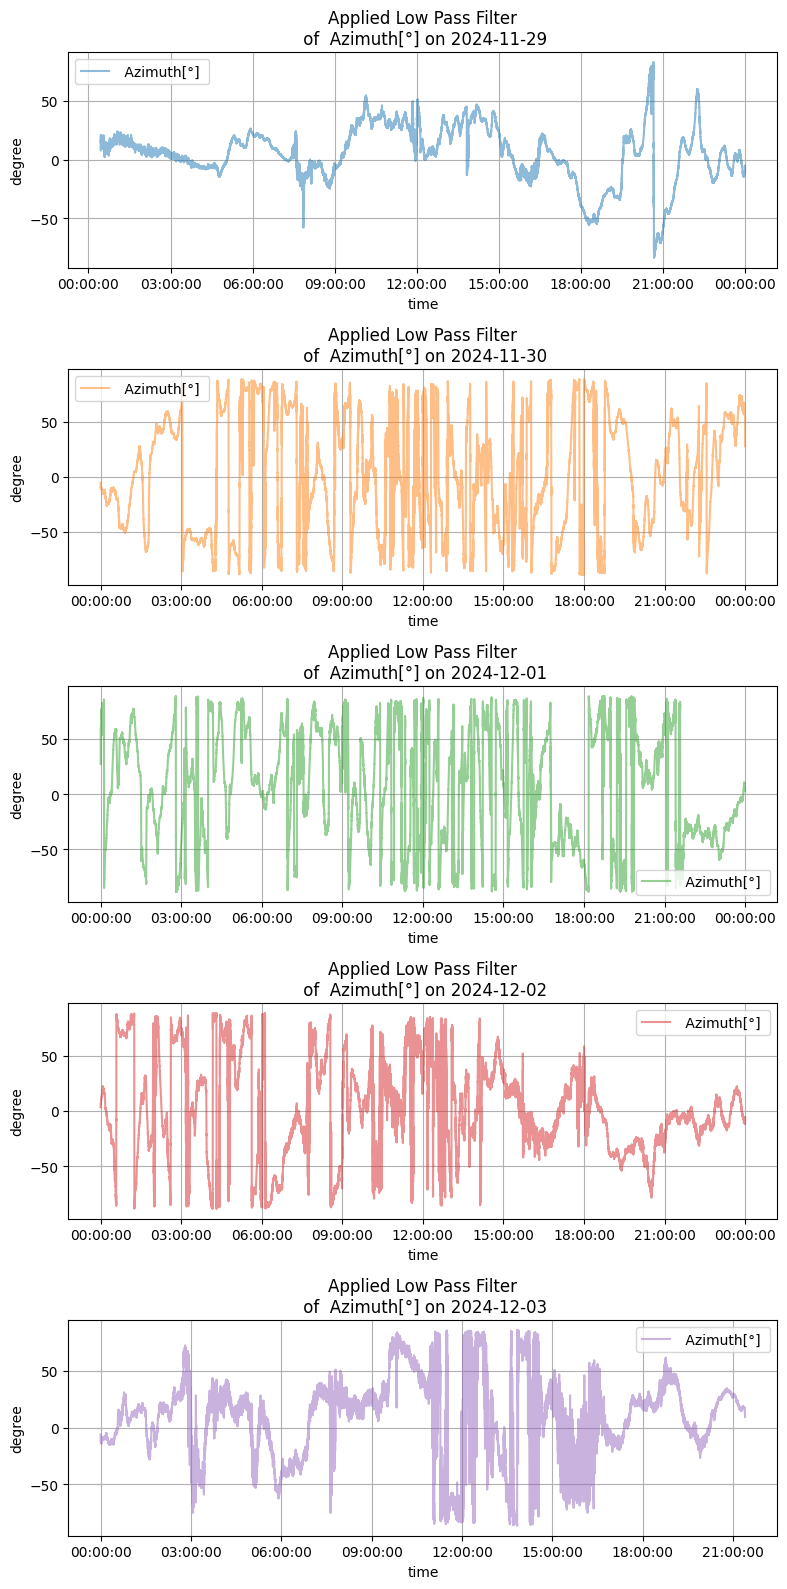

In [47]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)

    ax.plot(df_day.index, lps[:-1], label=columns[9], color=colors[i], alpha=0.5)
   
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied Low Pass Filter\n of {columns[9]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
        
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

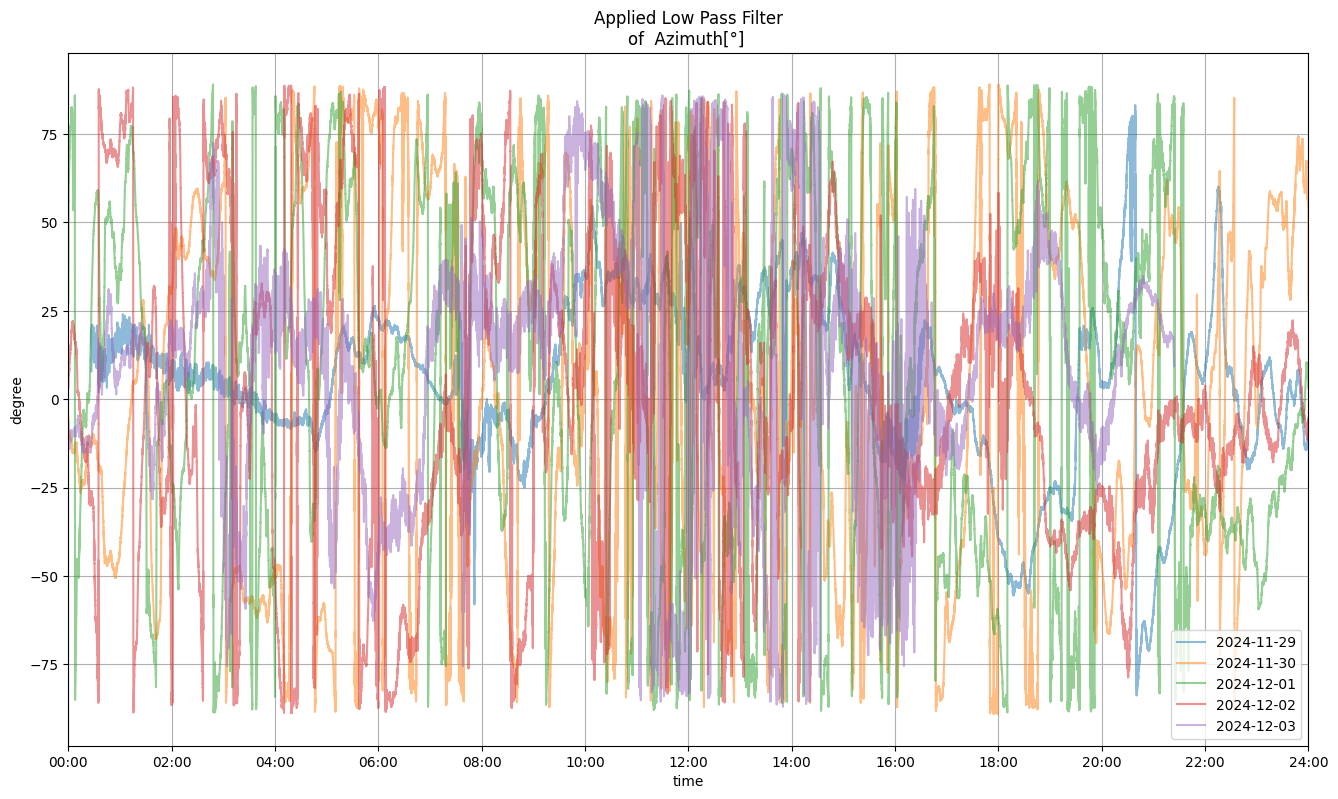

In [48]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in angle_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day[columns[9]])
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[9]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

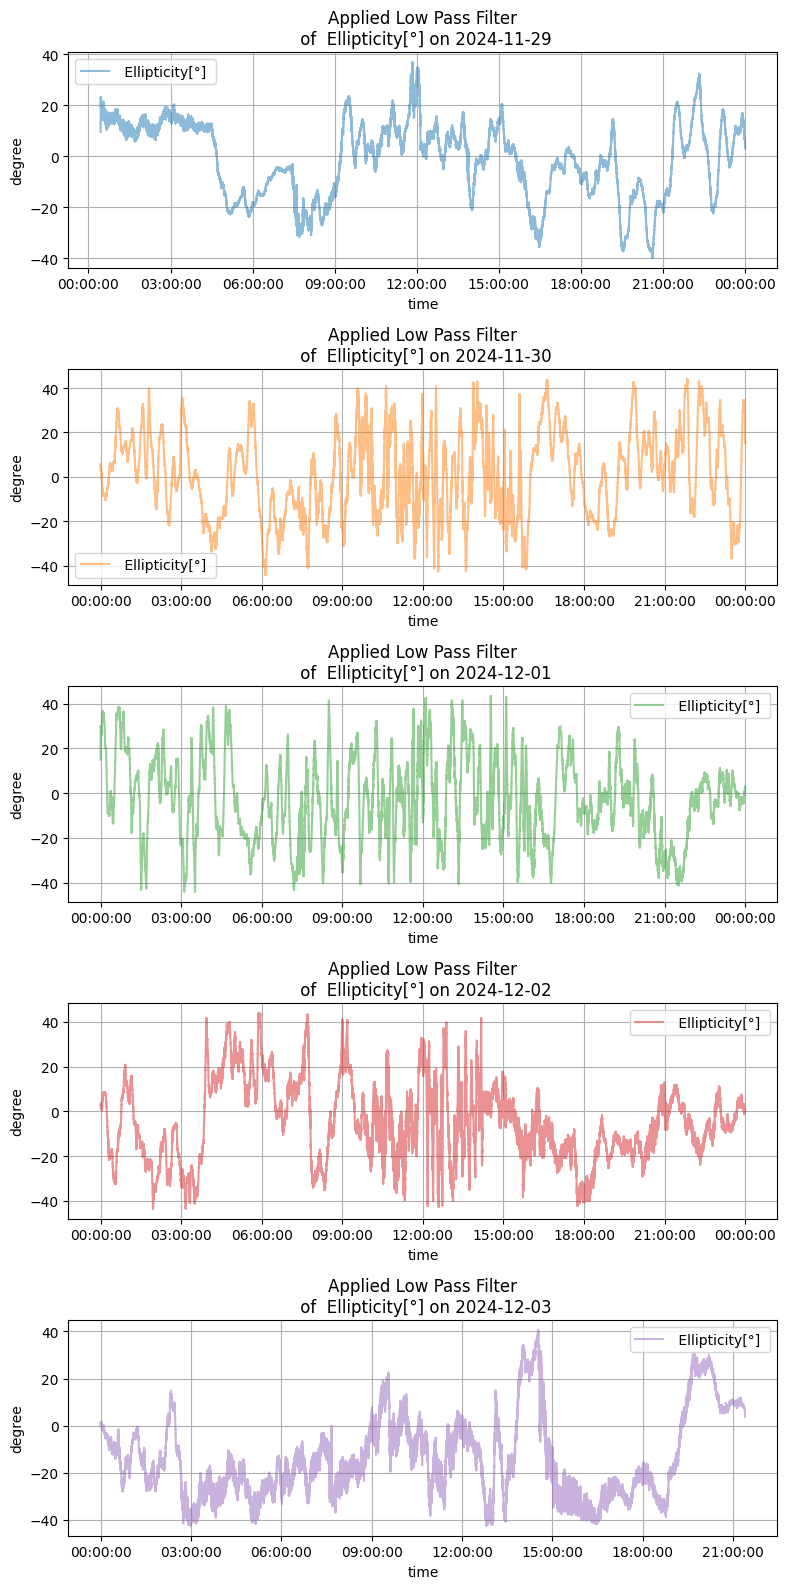

In [49]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)

    ax.plot(df_day.index, lps[:-1], label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied Low Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

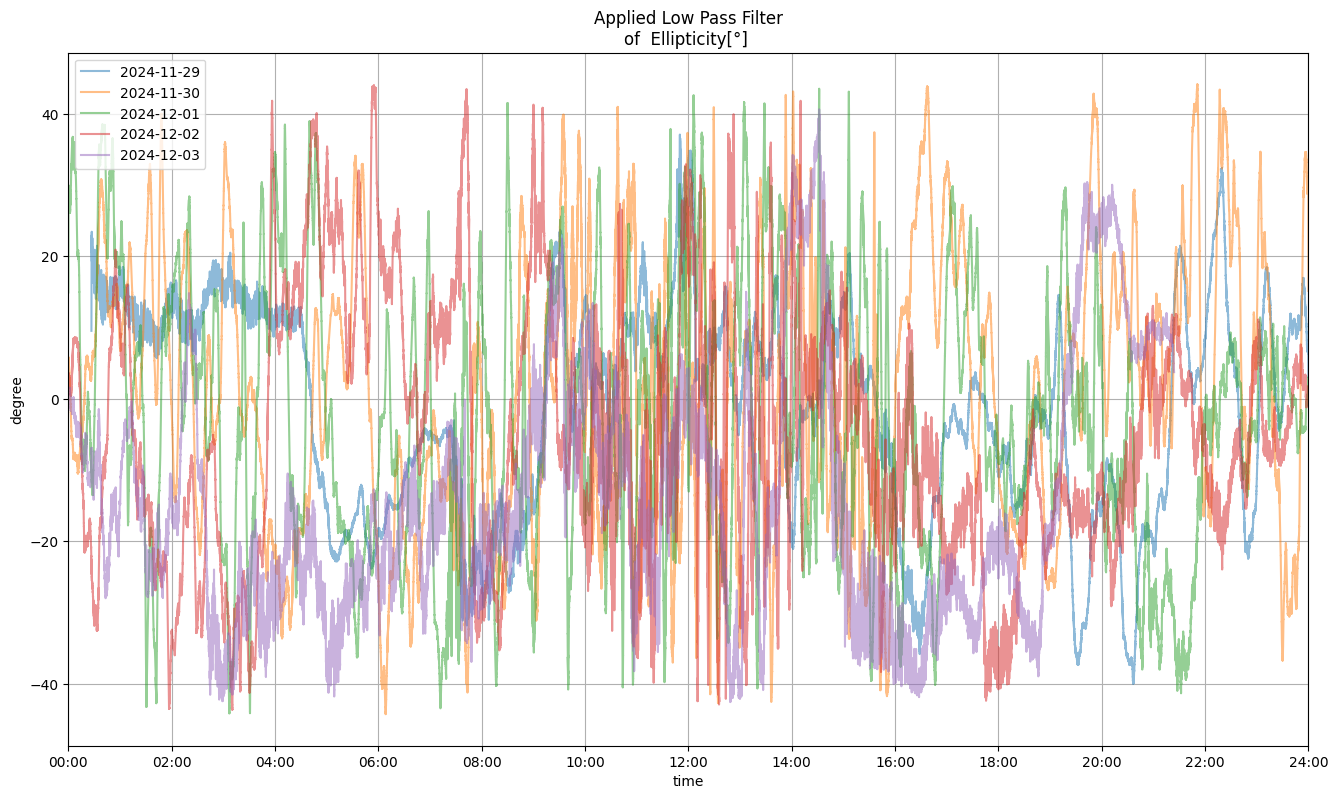

In [50]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in angle_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day[columns[10]])
    lps = lowpass(ydata, 100)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[10]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

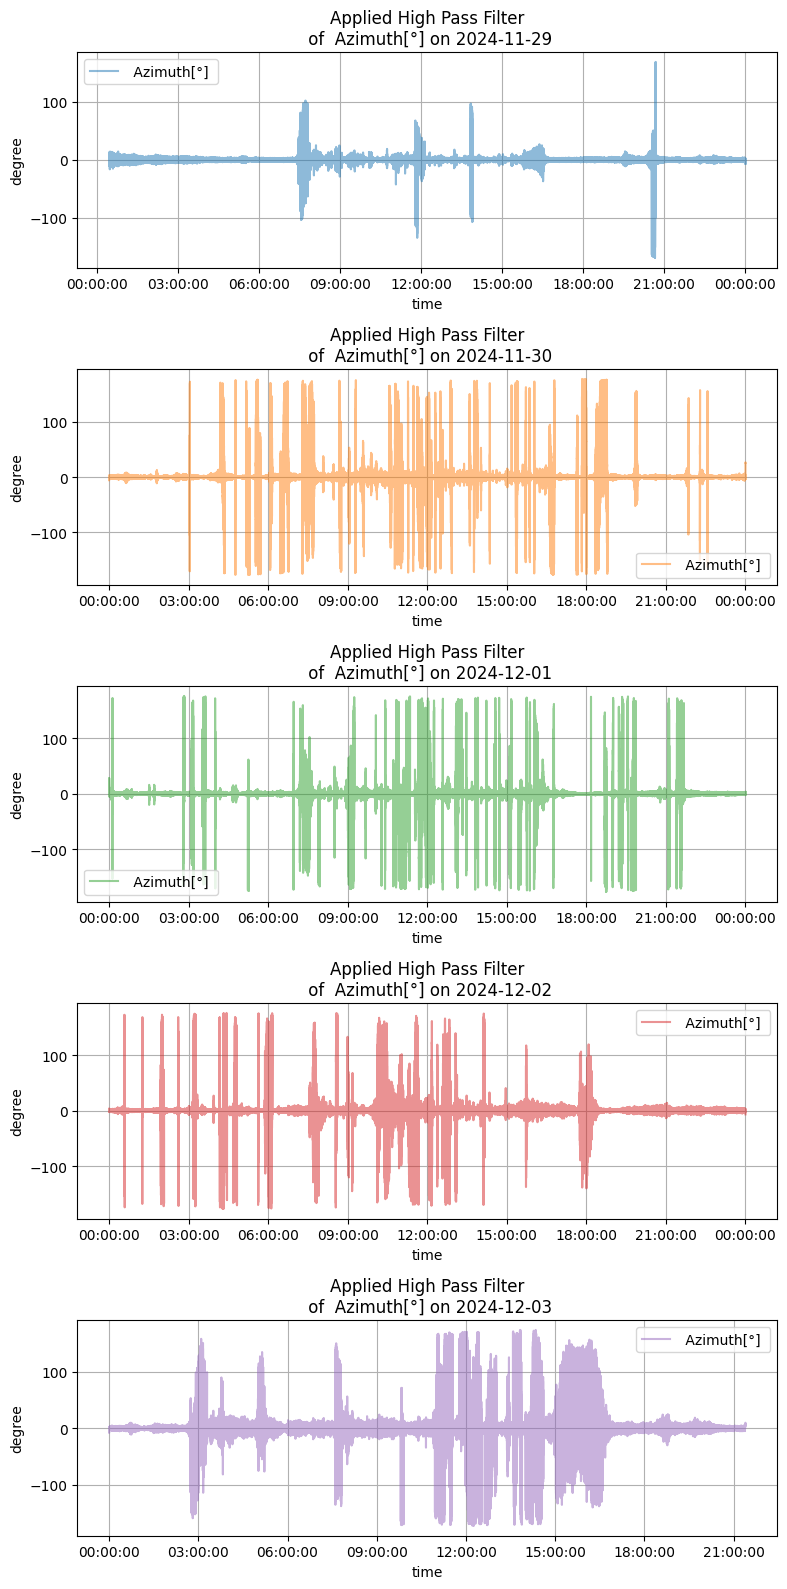

In [51]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)

    ax.plot(df_day.index, hps, label=columns[9], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied High Pass Filter\n of {columns[9]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

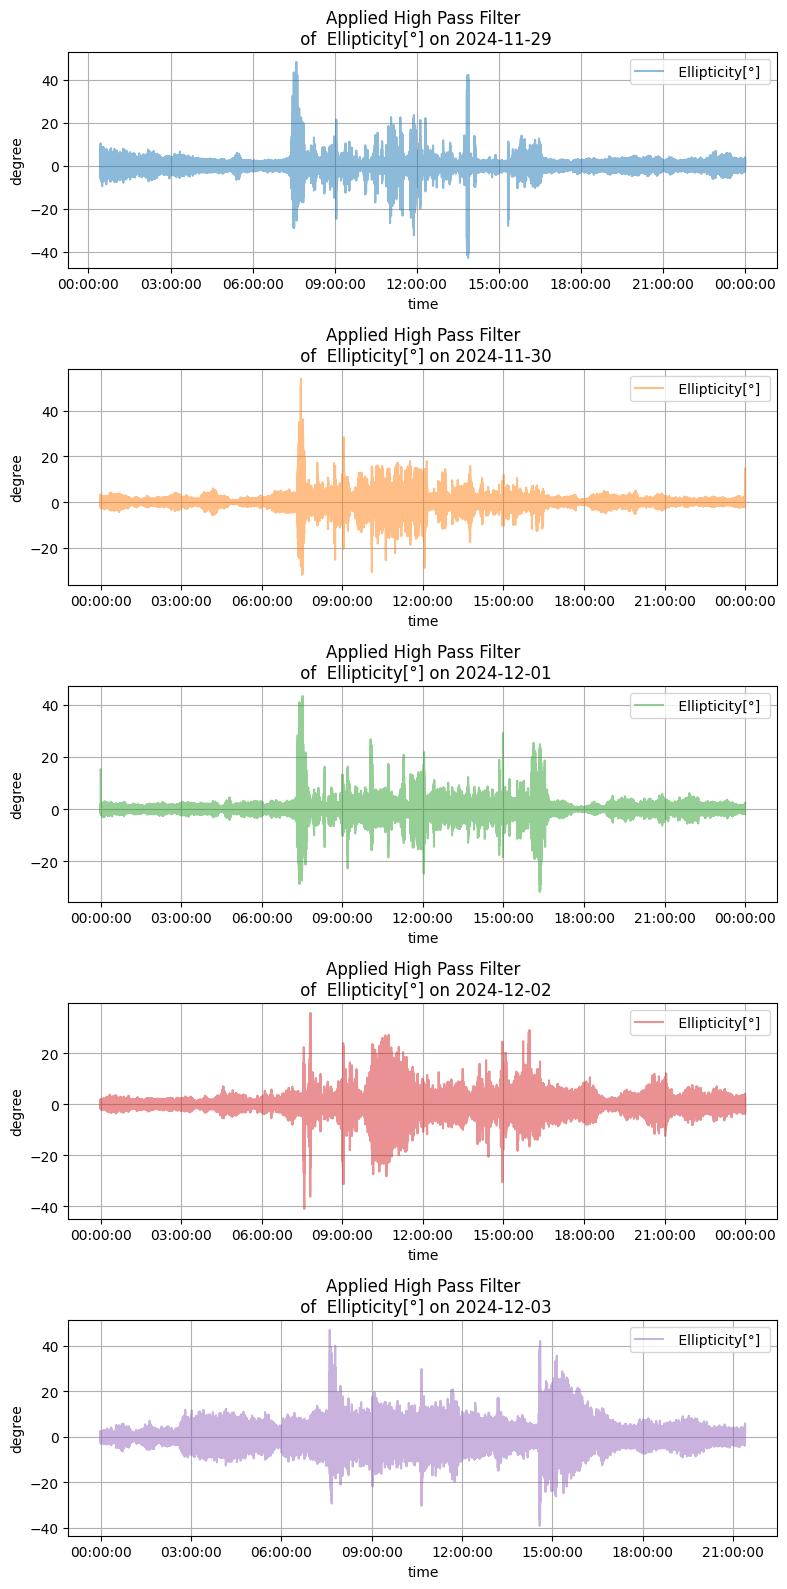

In [52]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)

    ax.plot(df_day.index, hps, label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied High Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Darstellung auf der Poincaré-Kugel
### Visualisierung mit dem Python-Tool [„py_pol“](https://py-pol.readthedocs.io/en/master/index.html)

In [53]:
one_second = datetime.timedelta(seconds=1)
one_minute = datetime.timedelta(minutes=1)
one_hour = datetime.timedelta(hours=1)
one_quater = datetime.timedelta(hours=6)
one_half = datetime.timedelta(hours=12)
one_day = datetime.timedelta(days=1)

start_time = datetime.datetime.strptime(str(angle.index[0]), '%Y-%m-%d %H:%M:%S.%f')
end_time_second = start_time + one_second
end_time_minute = start_time + one_minute
end_time_hour = start_time + one_hour
end_time_quater = start_time + one_quater
end_time_half = start_time + one_half
end_time_day = start_time + one_day

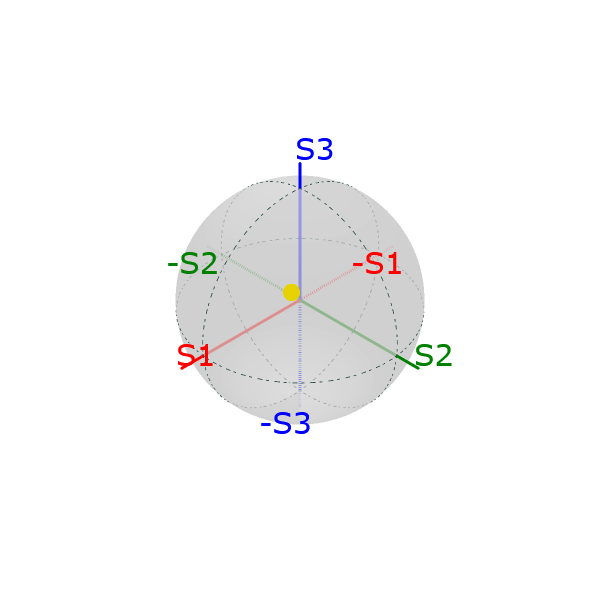

In [80]:
first_val = angle.iloc[0]

az = np.array(first_val[columns[9]]) * degrees
el = np.array(first_val[columns[10]]) * degrees

S = Stokes("Calculated Point")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_val.png")

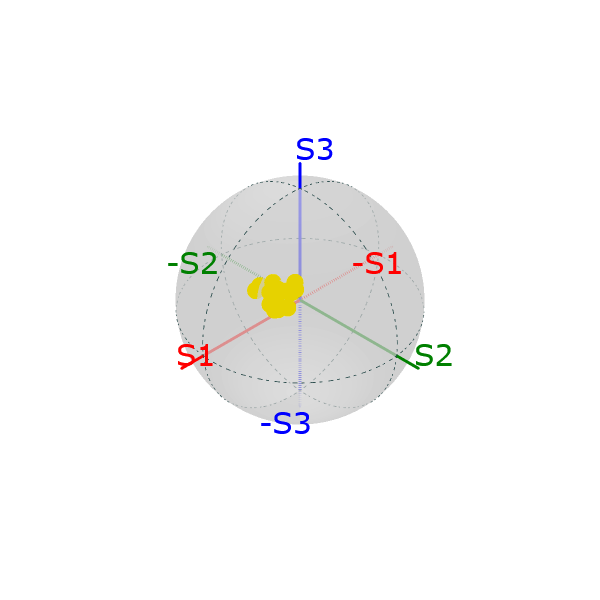

In [81]:
first_second = angle.loc[(angle.index >= start_time) & (angle.index < end_time_second)]

az = np.array(first_second[columns[9]].values) * degrees  
el = np.array(first_second[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_second.png")

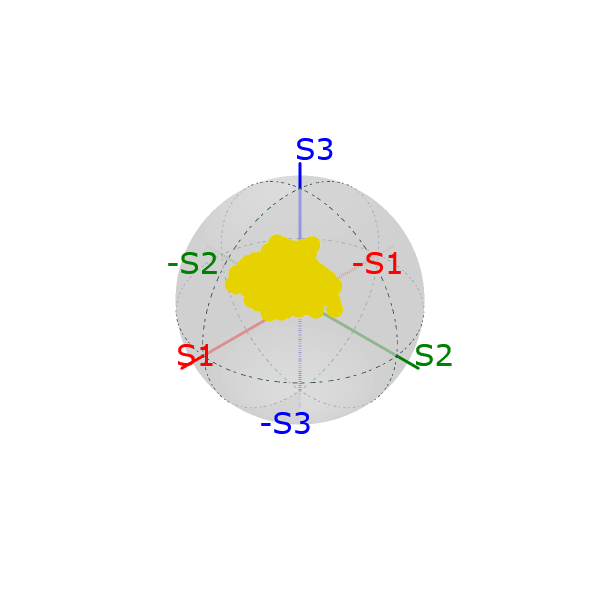

In [82]:
first_minute = angle.loc[(angle.index >= start_time) & (angle.index < end_time_minute)]

az = np.array(first_minute[columns[9]].values) * degrees
el = np.array(first_minute[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_minute.png")

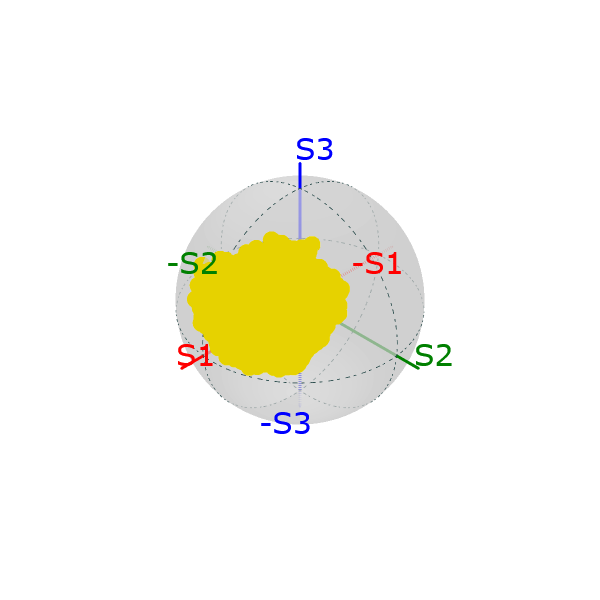

In [83]:
first_hour = angle.loc[(angle.index >= start_time) & (angle.index < end_time_hour)]

az = np.array(first_hour[columns[9]].values) * degrees
el = np.array(first_hour[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_hour.png")

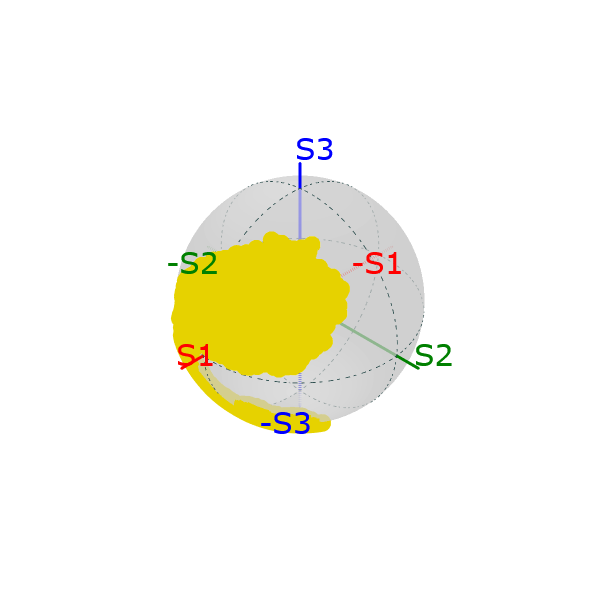

In [84]:
first_quater = angle.loc[(angle.index >= start_time) & (angle.index < end_time_quater)]

az = np.array(first_quater[columns[9]].values) * degrees
el = np.array(first_quater[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_quater.png")

### Eigene Berechnung und Visualisierung der Daten

In [59]:
normalized_stokes = pd.read_csv(filename,skiprows=skip, usecols=[columns[2], columns[3], columns[4]], sep=sep, nrows=19)
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)

data = pd.DataFrame({
    "S1": x,
    "Normalized S1": normalized_stokes[columns[2]],
    "S2": y,
    "Normalized S2": normalized_stokes[columns[3]],
    "S3": z,
    "Normalized S3": normalized_stokes[columns[4]]
})
print(data)

          S1  Normalized S1        S2  Normalized S2        S3  Normalized S3
0   0.596336           0.60  0.511483           0.51  0.618683           0.62
1   0.701573           0.70  0.488696           0.49  0.518624           0.52
2   0.700520           0.70  0.482535           0.48  0.525769           0.53
3   0.655133           0.66  0.534695           0.53  0.533762           0.53
4   0.646914           0.65  0.488193           0.49  0.585807           0.59
5   0.604898           0.60  0.497930           0.50  0.621421           0.62
6   0.550527           0.55  0.498488           0.50  0.669649           0.67
7   0.569661           0.57  0.523097           0.52  0.633921           0.63
8   0.613659           0.61  0.484291           0.48  0.623607           0.62
9   0.661133           0.66  0.472976           0.47  0.582407           0.58
10  0.720448           0.72  0.431179           0.43  0.543174           0.54
11  0.717083           0.72  0.469604           0.47  0.515038  

In [60]:
print("Original normalized S1 equals calculated S1? ", data['Normalized S1'].equals(round(data['S1'], 2)))
print("Original normalized S2 equals calculated S2? ", data['Normalized S2'].equals(round(data['S2'], 2)))
print("Original normalized S3 equals calculated S3? ", data['Normalized S3'].equals(round(data['S3'], 2)))

Original normalized S1 equals calculated S1?  True
Original normalized S2 equals calculated S2?  True
Original normalized S3 equals calculated S3?  True


In [62]:
#%matplotlib notebook # interaktiver Plot-Mode
%matplotlib inline # statischer Plot-Mode

UsageError: unrecognized arguments: # statischer Plot-Mode


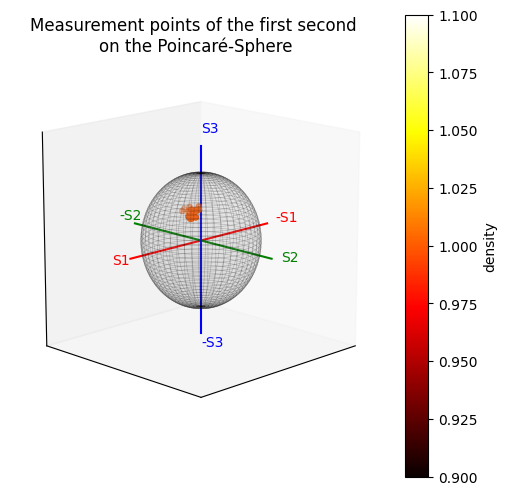

In [65]:
title = 'Measurement points of the first second \non the Poincaré-Sphere'
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

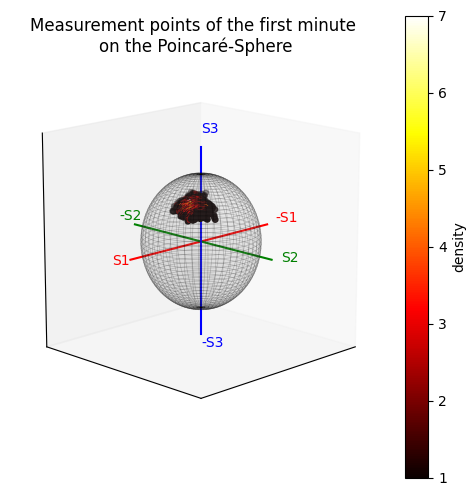

In [66]:
title = 'Measurement points of the first minute \non the Poincaré-Sphere'
x,y,z = convert_angel(first_minute[columns[9]].values, first_minute[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

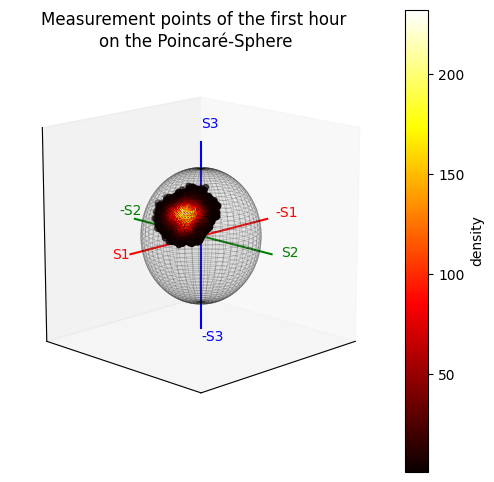

In [67]:
title = 'Measurement points of the first hour \non the Poincaré-Sphere'
x,y,z = convert_angel(first_hour[columns[9]].values, first_hour[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

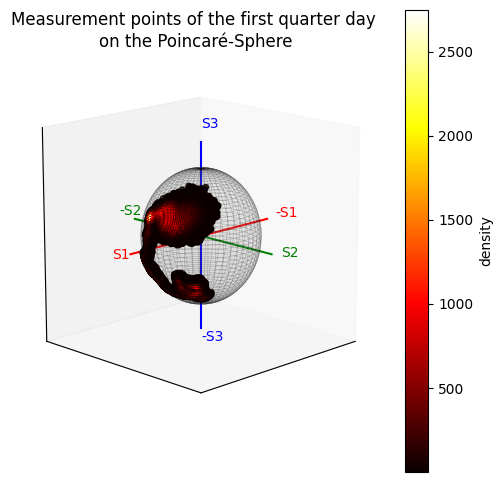

In [68]:
title = 'Measurement points of the first quarter day \non the Poincaré-Sphere'
x,y,z = convert_angel(first_quater[columns[9]].values, first_quater[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

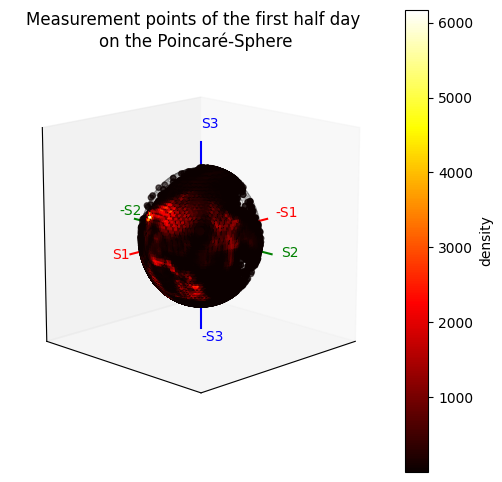

In [70]:
first_half = angle.loc[(angle.index >= start_time) & (angle.index < end_time_half)]

title = 'Measurement points of the first half day \non the Poincaré-Sphere'
x,y,z = convert_angel(first_half[columns[9]].values, first_half[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

In [71]:
angle_seconds_resample = angle.resample('s').mean().ffill()
angle_seconds_resample.head()

Azimuth[°]   Ellipticity[°] 
Time[date hh:mm:ss]                               
2024-11-29 00:26:44     19.217000        18.165000
2024-11-29 00:26:45     12.858095        18.943810
2024-11-29 00:26:46     17.388500        19.627000
2024-11-29 00:26:47     17.231053        19.551053
2024-11-29 00:26:48     15.330952        22.748571

In [72]:
print(angle_seconds_resample.isnull().sum())
print(type(angle.index))

Azimuth[°]         0
Ellipticity[°]     0
dtype: int64
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


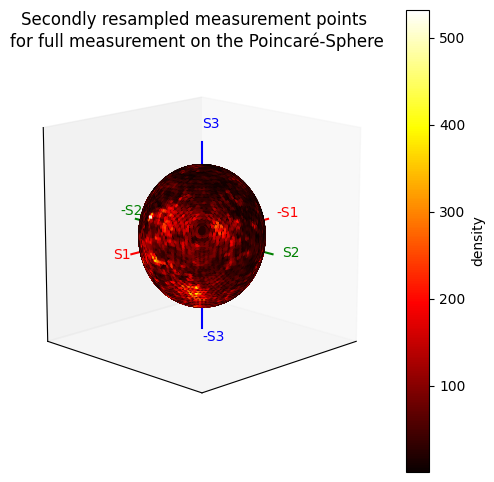

In [74]:
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'

x,y,z = convert_angel(angle_seconds_resample[columns[9]].values, angle_seconds_resample[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

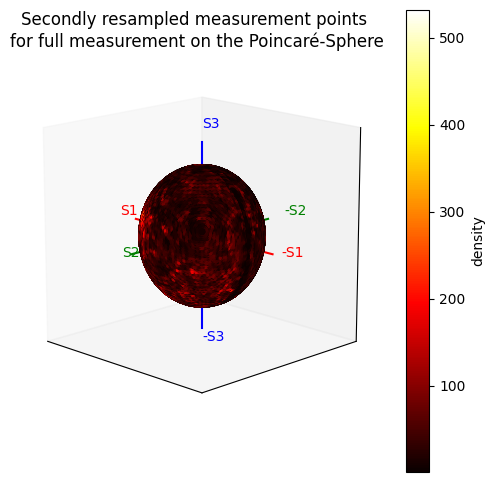

In [75]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=135, title=title)

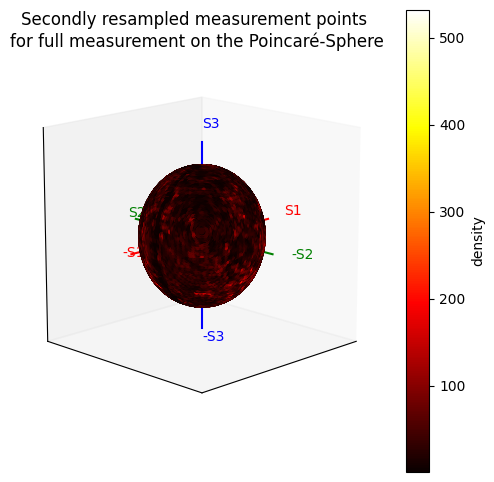

In [76]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=225, title=title)

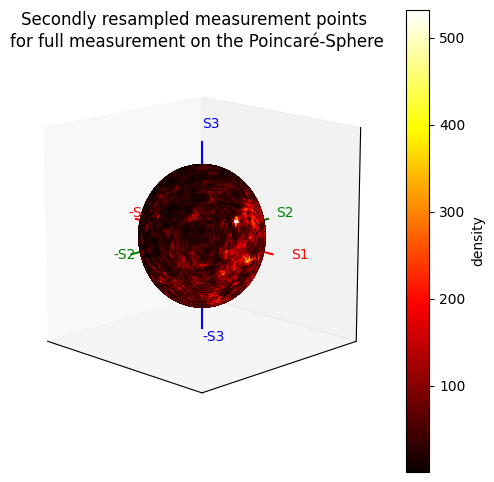

In [77]:
#elev=15, azim=45
title= 'Secondly resampled measurement points \nfor full measurement on the Poincaré-Sphere'
plot_poincare(x, y, z, freq, elev=15, azim=315, title=title)